# VVR ANALYSIS PART ONE
### “Prevention of vasovagal reactions in blood donors: A randomized double-blinded controlled comparison of efficacy and haemodynamic effects of oral prehydration fluids.” 
Ref No. 12130371.

This code prepared by Alex Nicol.

In [1]:
# packages used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy.stats as stats
from datetime import datetime
from kw_dunn_posthoc import kw_dunn

# formatting options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = "{:,.3f}".format

# load in data from csv file
df = pd.read_csv('VVR part 1 updated 2020_02_27.csv')

# preprocessing
datevariables = ['collection_date','dob_DDMMYY']
timevariables = ['hydration_time_HHMM','donation_start_hhmm','donation_end_hhmm']
for v in datevariables:
   df[v] = pd.to_datetime(df[v],errors='coerce')
for v in timevariables:
    df[v] = pd.to_timedelta(df[v],errors='coerce')
file_numvars = open('numvars.txt')
numvars = file_numvars.read().split("\n")
df[numvars] = df[numvars].apply(pd.to_numeric,errors='coerce')
df.donation_volume.replace(350,'350ml',inplace=True)
df.donation_volume.replace(450,'450ml',inplace=True)
df['don_vol_orig'] = df.donation_volume.values
df.donation_volume = df.donation_volume.apply(lambda x: x if x in ['350ml','450ml'] else np.nan)
df.don_vol_orig = df.don_vol_orig.apply(lambda x: x if x in ['350ml','450ml'] else  "incomplete")
BDRI_values = pd.Series(['not at all','to a slight degree','to a moderate degree',
            'to a strong degree','to a very strong degree','to an extreme degree']).to_dict()
BDRI_values = dict((v,k) for k,v in BDRI_values.items())
BDRI_cols = ["BDRI_#%d"%a for a in range(1,12)]
TQ_cols = ["TQ#%d"%a for a in range(1,12)]
df.loc[:,'STAI_Y1_#1':'TQ#14b'] = df.loc[:,'STAI_Y1_#1':'TQ#14b'].astype(str)
df[BDRI_cols] = df[BDRI_cols].replace(BDRI_values)
df[TQ_cols] = df[TQ_cols].replace(BDRI_values)
STAIY1_cols = ["STAI_Y1_#%d"%a for a in range(1,21)]
STAIY2_cols = ["STAI_Y2_#%d"%a for a in range(1,22)]
Y1_dict = { 'not at all':1, 'somewhat':2, 'moderately so':3,'very much so':4}
Y2_dict = {'almost never':1,'sometimes':2,'often':3,'almost always':4}
for c in STAIY1_cols:
    df[c] = df[c].replace(Y1_dict)
for c in STAIY2_cols:
    df[c] = df[c].replace(Y2_dict)
for a in BDRI_cols + TQ_cols + STAIY1_cols + STAIY2_cols:
    df[a] = pd.to_numeric(df[a],errors='coerce')
df.gender = df.gender.replace({1:'male',2:'female'})
df.donation_status = df.donation_status.replace({1:'first time',2:'repeated'})
#df.VVR_occurrence = df.VVR_occurrence.replace({0:'none',1:'immediate',2:'delayed',3:'both'})
df.VVR_occurrence = df.VVR_occurrence.replace({0:'none',1:'immediate_or_both',2:'delayed',3:'immediate_or_both'})
df['VVR_any']=df.VVR_occurrence.apply(lambda x: False if x=='none' else True)
df['VVR_immediate']=df.VVR_occurrence.apply(lambda x: True if x=='immediate' or x=='both' else False)
df['VVR_delayed']=df.VVR_occurrence.apply(lambda x: True if x=='delayed' or x=='both' else False)
df['BDRI_score'] = df[BDRI_cols].sum(axis=1,skipna=True)
df['BDRI_react'] = df['BDRI_score'] != 0
df['TQ_score'] = df[TQ_cols].sum(axis=1,skipna=True)
df['TQ_react'] = df['TQ_score'] != 0
df['STAIY1Score'] = df[STAIY1_cols].sum(axis=1,skipna=True)
df['STAIY2Score'] = df[STAIY2_cols].sum(axis=1,skipna=True)
df.rename(columns={'hb':'Hb'},inplace=True)
ppcols = ["Prehy_sit_PP",
"Prehy_stand_PP",
"Posthy_sit_PP",
"Posthy_ss_PP",
"Posthy_0.5ss_PP",
"Posthy_1ss_PP",
"Posthy_post5ss_PP",
"Posthy_post10ss_PP",
"Posthy_post10sit_PP",
"Posthy_post10stand_PP"]

for p in ppcols:
    df[p] = df[p[:-2]+"SBP"]-df[p[:-2]+"DBP"]
df['donation'] = df.donation_end_hhmm - df.donation_start_hhmm
df['donation'] = df['donation'].apply(lambda x: x.seconds/60)
#df['donation'] = pd.to_datetime(df.donation, errors='coerce')
import math
#df.donation = df.donation.dt.strftime('%M').replace('NaT',0).astype(int) + df.donation.dt.strftime('%S').replace('NaT',0).astype(int)//30
#df.donation.replace(0,np.nan,inplace=True)

HDparam = ['CO','SV','HR','SVR','SBP','DBP','MAP','PP']
eventnames = ["Prehy_sit_","Prehy_stand_","Posthy_sit_","Posthy_ss_",
"Posthy_0.5ss_","Posthy_1ss_","Posthy_post5ss_","Posthy_post10ss_",
"Posthy_post10sit_","Posthy_post10stand_"]
types = ["Control", "Placebo", "ORS"]
hdcols = []
for p in HDparam:
    for e in eventnames:
        hdcols.append(e+p)

incomplete_cases = {'M003','M010','M014','M016','M017','M018', 'M036',
       'M042', 'M043', 'M058', 'M064', 'M105', 'M125', 'M130', 'M132',
       'M133', 'M144', 'M148', 'M150', 'M159', 'M189', 'M191', 'M198',
       'M209','M215','F015','F017', 'F036', 'F048', 'F054', 'F061', 'F079',
       'F080', 'F083', 'F086', 'F092', 'F111', 'F115', 'F120', 'F146',
       'F150', 'F173', 'F192', 'F197', 'F205', 'F208', 'F215', 'F216',
       'F218', 'F220'}
to_omit = {'M036','M043','M064','M132','M191','M010','F061','F083','F086','F092','F115',
          'F146','F192'}
omit_events = {'M058':6}
omit_after_event = {'M105':7,'M209':6,'F173':6,'F197':5,'F220':6}

   

eventparams = ['USCOM#', 'Time', 'Vpk', 'Pmn', 'Vti', 'HR', 'MD', 'Etper', 'FT', 'SV', 'Svi',
     'CO', 'Ci', 'SBP', 'DBP', 'MAP', 'CVP', 'SVR', 'SVRi', 'SVV', 'FTc', 'SW', 'Cpo',
     'SVS', 'SpO2', 'Hb', 'DO2', 'Ino', 'PKr', 'discomfort', 'PP']

intergroups = {'a': (1, 10), 'b': (2, 10), 'c': (1, 3), 'd': (1, 9), 'e': (3, 10), 'f': (3, 9), 'f2': (9, 10)}
intergroup_labels = ['Prehy_sit to Posthy_post10stand', 'Prehy_stand to Posthy_post10stand','Prehy_sit to Posthy',
     'Prehy_sit to Posthy_post10sit','Posthy_sit to Posthy_post10stand','Posthy_sit to Posthy_post10sit','Posthy_post10sit to Posthy_post10stand']
HDparam = ['CO','SV','HR','SVR','SBP','DBP','MAP','PP']
eventnames = ["Prehy_sit_","Prehy_stand_","Posthy_sit_","Posthy_ss_",
    "Posthy_0.5ss_","Posthy_1ss_","Posthy_post5ss_","Posthy_post10ss_",
    "Posthy_post10sit_","Posthy_post10stand_"]
types = ["Control", "Placebo", "ORS"]  
    
    
inc_isolated = True
    
if not inc_isolated:
    print('Without isolated cases')
    df = df[df['case#'].apply(lambda x: x not in incomplete_cases)]
else:
    print('Including isolated cases')
    print("Cases omitted:")
    [print(o,end=', ') for o in to_omit]
    print("\nSpecific events removed:")
    for c,e in omit_events.items():
        print("Case %s, event %d removed"%(c,e))
        for param in eventparams:
            df.loc[df['case#']==c,eventnames[e-1]+param] = np.nan
    for c,e in omit_after_event.items():
        print("Case %s, events after event # %d removed"%(c,e))
        for param in eventparams:
            for event in eventnames[e:]:
                df.loc[df['case#']==c,event+param] = np.nan  
    df = df[df['case#'].apply(lambda x: x not in to_omit)] 

Including isolated cases
Cases omitted:
M010, F146, F115, F192, M064, F092, M043, M132, M036, F083, F086, F061, M191, 
Specific events removed:
Case M058, event 6 removed
Case M105, events after event # 7 removed
Case M209, events after event # 6 removed
Case F173, events after event # 6 removed
Case F197, events after event # 5 removed
Case F220, events after event # 6 removed


In [2]:
def contingency_analyse(table,tail='two-sided',alpha=0.05):
    """
    table: a NxM contingency table (np array or pandas object)
    tail: one of {'two-sided', 'less', 'greater'}
    """
    if type(table) == pd.core.frame.DataFrame:
        table = table.values
    if table.min() < 5:
        test = 'Fisher Exact Test (small sample size)'
        odds, p = stats.fisher_exact(table,tail)
    else:
        test = 'Chi-squared correlation test'
        if tail == 'less':
            _,p,_,_ = stats.chi2_contingency(table,correction=False)
        else:
            _,p,_,_ = stats.chi2_contingency(table,correction=True)
        if table.shape == (2,2):
            a,b,c,d = table.flatten()
            odds = (a/b)/(c/d)
    if 'odds' in locals():
        err = stats.norm.ppf(1-(alpha/2))*np.sqrt(np.sum(1/table))
        ci = "(%.2f, %.2f)"%(np.exp(np.log(odds) - err ), np.exp(np.log(odds) + err ))
        return pd.DataFrame(pd.Series({'p value':p, 'odds ratio':odds, 'CI on OR':ci},name=test))
    else:
        return pd.DataFrame(pd.Series({'p value':p},name=test))

# Demographics

In [3]:
demos = ['age','weight','height','donation_percent','EBV']
demos += [e+p for (e,p) in itertools.product([eventnames[0]],['SBP','DBP','HR','CO','SV','SVR','MAP'])]
demos += ['STAIY1Score','STAIY2Score','STAI_Y2_#21']
res = pd.DataFrame(index=pd.MultiIndex.from_product([demos,types]),columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for d in demos:
    for t in types:
        res.loc[(d,t),:] = df.groupby('type')[d].get_group(t).describe()
    stat,p_omni,zpair,p_corr,_ = kw_dunn([df.groupby('type')[d].get_group(t) for t in types]);
    pairs = list(itertools.combinations(types,2))
    res.loc[d,'Kruskal-Wallis p'] = p_omni
    for i, pc in enumerate(p_corr):
        res.loc[d," - ".join(pairs[i])] = pc
res.drop(['25%','75%'],1,inplace=True)
res.columns.name = 'Demographics by Hydration Type'
display(res)

vvrs = list(np.unique(df.VVR_occurrence))
res = pd.DataFrame(index=pd.MultiIndex.from_product([demos,vvrs]),columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for d in demos:
    for t in vvrs:
        res.loc[(d,t),:] = df.groupby('VVR_occurrence')[d].get_group(t).describe()
    stat,p_omni,zpair,p_corr,_ = kw_dunn([df.groupby('VVR_occurrence')[d].get_group(t) for t in vvrs]);
    pairs = list(itertools.combinations(vvrs,2))
    res.loc[d,'Kruskal-Wallis p'] = p_omni
    for i, pc in enumerate(p_corr):
        res.loc[d," - ".join(pairs[i])] = pc
res.index.names = ['Parameter','VVR']
res.columns.name = 'Demographics by VVR Occurrence'
display(res)

res = pd.DataFrame(index=pd.MultiIndex.from_product([demos,vvrs,types]),columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for d in demos:
    for v in vvrs:
        vtype = np.unique(df[df.VVR_occurrence==v]['type'])
        for t in vtype:
            res.loc[(d,v,t)] = df.groupby(['VVR_occurrence','type'])[d].get_group((v,t)).describe()
        if len(vtype)<2:
            continue
        stat,p_omni,zpair,p_corr,_ = kw_dunn([df.groupby(['VVR_occurrence','type'])[d].get_group((v,t)) for t in vtype]);
        pairs = list(itertools.combinations(vtype,2))
        res.loc[(d,v),'Kruskal-Wallis p'] = p_omni
        for i, pc in enumerate(p_corr):
            res.loc[(d,v)," - ".join(pairs[i])] = pc
res.drop(['25%','75%'],1,inplace=True)
res.index.names = ['Parameter','VVR','type']
res.columns.name = 'Demographics by VVR Occurrence and hydration type'
display(res)

Demographics by Hydration Type   count      mean     std       min       50%  \
age              Control       144.000    19.750   2.319     0.000    20.000   
                 Placebo       143.000    19.517   1.694    16.000    20.000   
                 ORS           142.000    19.768   1.687    16.000    20.000   
weight           Control       144.000    60.278   9.931    44.350    59.000   
                 Placebo       143.000    59.898   8.761    43.600    59.900   
                 ORS           142.000    60.445  10.780    43.000    59.000   
height           Control       144.000   166.875   8.322   150.000   168.000   
                 Placebo       143.000   166.818   8.085   150.000   167.000   
                 ORS           142.000   167.251   9.218   149.000   167.000   
donation_percent Control       144.000    10.197   1.847     2.691    10.211   
                 Placebo       143.000    10.404   1.744     2.472    10.353   
                 ORS           142.000    10.291   1.702     3.458    10.119   
EBV              Control       144.000     4.051   0.692     2.874     4.021   
                 Placebo       143.000     4.035   0.636     2.914     3.984   
                 ORS           142.000     4.071   0.757     2.879     4.078   
Prehy_sit_SBP    Control       144.000   117.903  11.905    92.000   116.000   
                 Placebo       143.000   116.741  13.386    85.000   116.000   
                 ORS           142.000   118.077  11.635    90.000   117.000   
Prehy_sit_DBP    Control       144.000    76.576   8.122    54.000    77.000   
                 Placebo       143.000    75.888   8.128    56.000    75.000   
                 ORS           142.000    76.042   7.750    58.000    76.500   
Prehy_sit_HR     Control       144.000    67.192  10.549    43.696    66.945   
                 Placebo       143.000    67.704  11.012    44.425    66.496   
                 ORS           142.000    66.834  10.248    45.057    66.569   
Prehy_sit_CO     Control       144.000     4.139   0.874     2.446     3.998   
                 Placebo       143.000     4.136   0.895     2.448     3.972   
                 ORS           142.000     4.077   0.951     1.450     4.102   
Prehy_sit_SV     Control       144.000    62.419  13.158    35.098    61.157   
                 Placebo       143.000    61.745  12.028    30.752    60.601   
                 ORS           142.000    61.563  13.249    27.484    61.370   
Prehy_sit_SVR    Control       144.000 1,825.787 392.771 1,089.665 1,785.749   
                 Placebo       143.000 1,819.279 434.471 1,110.215 1,777.956   
                 ORS           142.000 1,873.822 487.684   988.668 1,748.992   
Prehy_sit_MAP    Control       144.000    90.352   8.624    71.667    90.000   
                 Placebo       143.000    89.506   9.115    65.667    89.667   
                 ORS           142.000    90.054   8.457    69.333    91.333   
STAIY1Score      Control       144.000    41.667   7.970     0.000    42.000   
                 Placebo       143.000    42.832   5.254    28.000    43.000   
                 ORS           142.000    42.768   4.784    31.000    43.000   
STAIY2Score      Control       144.000    45.750   8.385     0.000    46.000   
                 Placebo       143.000    45.881   5.629    27.000    47.000   
                 ORS           142.000    46.585   5.035    35.000    47.000   
STAI_Y2_#21      Control       141.000     1.546   0.692     1.000     1.000   
                 Placebo       143.000     1.448   0.577     1.000     1.000   
                 ORS           142.000     1.373   0.554     1.000     1.000   

Demographics by Hydration Type       max  Kruskal-Wallis p  Control - Placebo  \
age              Control          22.000             0.192              0.253   
                 Placebo          22.000             0.192              0.253   
                 ORS              22.000             0.192              0.25

Demographics by VVR Occurrence       count      mean     std       min  \
Parameter        VVR                                                     
age              delayed            40.000    19.925   1.817    16.000   
                 immediate_or_both  11.000    19.636   1.567    17.000   
                 none              378.000    19.653   1.946     0.000   
weight           delayed            40.000    58.032   8.147    45.000   
                 immediate_or_both  11.000    60.555  10.094    49.000   
                 none              378.000    60.426   9.986    43.000   
height           delayed            40.000   163.575   7.923   149.000   
                 immediate_or_both  11.000   166.364   8.524   156.000   
                 none              378.000   167.359   8.539   149.000   
donation_percent delayed            40.000    11.117   1.666     7.013   
                 immediate_or_both  11.000     9.507   1.964     6.763   
                 none              378.000    10.233   1.746     2.472   
EBV              delayed            40.000     3.798   0.600     2.998   
                 immediate_or_both  11.000     4.066   0.705     3.182   
                 none              378.000     4.078   0.700     2.874   
Prehy_sit_SBP    delayed            40.000   112.675  11.693    85.000   
                 immediate_or_both  11.000   120.000   9.176   105.000   
                 none              378.000   118.021  12.369    89.000   
Prehy_sit_DBP    delayed            40.000    74.150   7.708    56.000   
                 immediate_or_both  11.000    79.727   6.482    72.000   
                 none              378.000    76.280   8.024    54.000   
Prehy_sit_HR     delayed            40.000    69.742  11.344    45.057   
                 immediate_or_both  11.000    70.295   7.687    59.204   
                 none              378.000    66.891  10.553    43.696   
Prehy_sit_CO     delayed            40.000     4.220   0.879     2.347   
                 immediate_or_both  11.000     3.990   1.025     2.692   
                 none              378.000     4.110   0.906     1.450   
Prehy_sit_SV     delayed            40.000    61.017  11.172    39.595   
                 immediate_or_both  11.000    56.718  11.767    42.882   
                 none              378.000    62.157  12.979    27.484   
Prehy_sit_SVR    delayed            40.000 1,736.268 456.346 1,170.508   
                 immediate_or_both  11.000 1,964.171 411.646 1,258.647   
                 none              378.000 1,846.815 437.678   988.668   
Prehy_sit_MAP    delayed            40.000    86.992   8.748    65.667   
                 immediate_or_both  11.000    93.152   6.431    84.333   
                 none              378.000    90.194   8.723    69.000   
STAIY1Score      delayed            40.000    42.850   4.222    34.000   
                 immediate_or_both  11.000    31.000  20.678     0.000   
                 none              378.000    42.706   5.127    28.000   
STAIY2Score      delayed            40.000    47.475   4.992    36.000   
                 immediate_or_both  11.000    33.909  22.043     0.000   
                 none              378.000    46.275   5.310    27.000   
STAI_Y2_#21      delayed            40.000     1.450   0.677     1.000   
                 immediate_or_both   8.000     1.500   0.535     1.000   
                 none              378.000     1.455   0.609     1.000   

Demographics by VVR Occurrence           25%       50%       75%       max  \
Parameter        VVR                                                         
age              delayed              19.000    20.000    21.000    22.000   
                 immediate_or_both    19.000    19.000    20.500    22.000   
                 none                 18.000    20.000    21.000    22.000   
weight           delayed              52.000    57.500    63.125    78.000   
                 immediate_or_both    54.650    55.70

C:\Users\alexa\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2876: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\alexa\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
C:\Users\alexa\Dropbox\VVR\kw_dunn_posthoc.py:60: UserWarning: Sample sizes < 5 are not recommended (K-W test assumes a chi square distribution)
  warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "


Demographics by VVR Occurrence and hydration type   count      mean     std  \
Parameter        VVR               type                                       
age              delayed           Control         11.000    20.091   1.758   
                                   Placebo         16.000    20.062   1.482   
                                   ORS             13.000    19.615   2.293   
                 immediate_or_both Control          8.000    20.250   1.282   
                                   Placebo          1.000    18.000     NaN   
                                   ORS              2.000    18.000   1.414   
                 none              Control        125.000    19.688   2.414   
                                   Placebo        126.000    19.460   1.714   
                                   ORS            127.000    19.811   1.617   
weight           delayed           Control         11.000    60.255   9.940   
                                   Placebo         16.000    57.850   8.065   
                                   ORS             13.000    56.377   6.673   
                 immediate_or_both Control          8.000    62.500  10.894   
                                   Placebo          1.000    49.000     NaN   
                                   ORS              2.000    58.550   4.031   
                 none              Control        125.000    60.138   9.936   
                                   Placebo        126.000    60.244   8.819   
                                   ORS            127.000    60.891  11.123   
height           delayed           Control         11.000   162.909   8.203   
                                   Placebo         16.000   165.000   8.408   
                                   ORS             13.000   162.385   7.411   
                 immediate_or_both Control          8.000   167.750   8.763   
                                   Placebo          1.000   157.000     NaN   
                                   ORS              2.000   165.500   9.192   
                 none              Control        125.000   167.168   8.282   
                                   Placebo        126.000   167.127   8.030   
                                   ORS            127.000   167.776   9.296   
donation_percent delayed           Control         11.000    10.997   1.742   
                                   Placebo         16.000    11.219   1.665   
                                   ORS             13.000    11.092   1.732   
                 immediate_or_both Control          8.000     9.578   2.281   
                                   Placebo          1.000    10.150     NaN   
                                   ORS              2.000     8.904   0.984   
                 none              Control        125.000    10.167   1.820   
                                   Placebo        126.000    10.302   1.740   
                                   ORS            127.000    10.230   1.688   
EBV              delayed           Control         11.000     3.840   0.701   
                                   Placebo         16.000     3.892   0.617   
                                   ORS             13.000     3.647   0.497   
                 immediate_or_both Control          8.000     4.204   0.739   
                                   Placebo          1.000     3.182     NaN   
                                   ORS              2.000     3.955   0.437   
                 none              Control        125.000     4.059   0.690   
                                   Placebo        126.000     4.060   0.636   
                                   ORS            127.000     4.116   0.771   
Prehy_sit_SBP    delayed           Control         11.000   114.545  11.953   
                                   Placebo         16.000   114.250  14.154   
                                   ORS             13.000   109.154   7.414   
                 immediate_or_both Control        

# Hydration Types

## Intergroups

In [4]:
if len(df.gender.unique()) == 1:
    display(pd.pivot_table(data=df,values='case#',index='type',columns=['don_vol_orig','donation_status'],margins=True,aggfunc='count',fill_value=0))
elif len(df.donation_volume.unique()) == 1:
    display(pd.pivot_table(data=df,values='case#',index='type',columns=['gender'],margins=True,aggfunc='count',fill_value=0))
else:
    display(pd.pivot_table(data=df,values='case#',index='type',columns=['gender','don_vol_orig'],margins=True,aggfunc='count',fill_value=0))
    
#get table of means
res = pd.DataFrame(index = pd.MultiIndex.from_product([HDparam,types+['All']],names=['Parameter','Type']), columns = intergroups.keys())
for param in HDparam:
    Event = [e+param for e in eventnames]
    for t in types+['All']:
        row = {}
        for i in intergroups.keys():
            (a,b) = intergroups[i]
            if t == 'All':
                data = (df[Event[a-1]] - df[Event[b-1]])/df[Event[a-1]]
                row[i] = "%.2f$\pm$%.2f"%(data.mean(),data.std())
            else:
                data = (df[df.type==t][Event[a-1]] - df[df.type==t][Event[b-1]])/df[Event[a-1]]
                row[i] = "%.2f$\pm$%.2f"%(data.mean(),data.std())
        res.loc[(param,t)] = pd.Series(row)
res.columns.name = 'Intergroup rel. diff. ($\mu\pm\sigma$)'
res.columns = [": ".join(i) for i in list(zip(intergroups.keys(),intergroup_labels))]
display(res)



gender       female                   male                   All
don_vol_orig  350ml 450ml incomplete 350ml 450ml incomplete     
type                                                            
Control          36    33          4    18    49          4  144
ORS              38    31          3    11    55          4  142
Placebo          29    39          5    12    55          3  143
All             103   103         12    41   159         11  429

a: Prehy_sit to Posthy_post10stand  \
Parameter Type                                         
CO        Control                      0.11$\pm$0.23   
          Placebo                      0.17$\pm$0.21   
          ORS                          0.05$\pm$0.22   
          All                          0.11$\pm$0.22   
SV        Control                      0.32$\pm$0.17   
          Placebo                      0.35$\pm$0.14   
          ORS                          0.28$\pm$0.17   
          All                          0.32$\pm$0.17   
HR        Control                     -0.33$\pm$0.23   
          Placebo                     -0.28$\pm$0.21   
          ORS                         -0.34$\pm$0.25   
          All                         -0.31$\pm$0.23   
SVR       Control                     -0.25$\pm$0.34   
          Placebo                     -0.30$\pm$0.34   
          ORS                         -0.16$\pm$0.30   
          All                         -0.24$\pm$0.33   
SBP       Control                     -0.05$\pm$0.11   
          Placebo                     -0.02$\pm$0.12   
          ORS                         -0.05$\pm$0.11   
          All                         -0.04$\pm$0.11   
DBP       Control                     -0.02$\pm$0.12   
          Placebo                     -0.01$\pm$0.12   
          ORS                         -0.04$\pm$0.10   
          All                         -0.03$\pm$0.11   
MAP       Control                     -0.03$\pm$0.10   
          Placebo                     -0.01$\pm$0.10   
          ORS                         -0.04$\pm$0.08   
          All                         -0.03$\pm$0.09   
PP        Control                     -0.12$\pm$0.32   
          Placebo                     -0.06$\pm$0.38   
          ORS                         -0.10$\pm$0.32   
          All                         -0.09$\pm$0.34   

                  b: Prehy_stand to Posthy_post10stand c: Prehy_sit to Posthy  \
Parameter Type                                                                  
CO        Control                        0.04$\pm$0.22         -0.07$\pm$0.15   
          Placebo                        0.09$\pm$0.22          0.00$\pm$0.13   
          ORS                           -0.04$\pm$0.24         -0.10$\pm$0.19   
          All                            0.03$\pm$0.24         -0.06$\pm$0.17   
SV        Control                        0.16$\pm$0.19         -0.10$\pm$0.13   
          Placebo                        0.18$\pm$0.18         -0.01$\pm$0.13   
          ORS                            0.09$\pm$0.21         -0.12$\pm$0.16   
          All                            0.14$\pm$0.20         -0.08$\pm$0.15   
HR        Control                       -0.15$\pm$0.17          0.02$\pm$0.08   
          Placebo                       -0.12$\pm$0.18          0.02$\pm$0.07   
          ORS                           -0.17$\pm$0.18          0.02$\pm$0.08   
          All                           -0.15$\pm$0.18          0.02$\pm$0.08   
SVR       Control                       -0.07$\pm$0.29          0.04$\pm$0.15   
          Placebo                       -0.10$\pm$0.28          0.00$\pm$0.13   
          ORS                            0.00$\pm$0.25          0.06$\pm$0.17   
          All                           -0.06$\pm$0.28          0.03$\pm$0.15   
SBP       Control                        0.02$\pm$0.11          0.00$\pm$0.06   
          Placebo                        0.06$\pm$0.10          0.02$\pm$0.07   
          ORS                            0.01$\pm$0.10         -0.00$\pm$0.06   
          All                            0.03$\pm$0.11          0.01$\pm$0.07   
DBP       Control                        0.03$\pm$0.11         -0.01$\pm$0.09   
          Placebo                        0.05$\pm$0.10          0.02$\pm$0.08   
          ORS                            0.02$\pm$0.08         -0.02$\pm$0.08   
          All                            0.03$\pm$0.10         -0.00$\pm$0.08   
MAP    

In [5]:
pairs = list(itertools.combinations(types,2))
res = pd.DataFrame(index = pd.MultiIndex.from_product([HDparam,pairs],names=['Parameter','Type']), columns = intergroups.keys())
res2 = pd.DataFrame(index=HDparam, columns=intergroups.keys())
for param in HDparam:
    Event = [e+param for e in eventnames]
    for i in intergroups.keys():
        (a,b) = intergroups[i]
        H,p_omni,Z_pairs,p_corr,reject = kw_dunn([((df[df.type==t][Event[a-1]]-df[df.type==t][Event[b-1]])/df[df.type==t][Event[a-1]]).dropna(axis=0) for t in types])          
        res2.loc[param,i] = p_omni
        for j,p in enumerate(p_corr):
            res.loc[(param,pairs[j]),i] = p
res2.columns.name = 'Kruskal-Wallis p-values (comparing hydration type)'
res.columns.name = 'Dunn-Bonferroni post hocs p-values'
display(res2)
display(res)

Kruskal-Wallis p-values (comparing hydration type),a,b,c,d,e,f,f2
CO,0.000,0.000,0.000,0.000,0.083,0.464,0.313
SV,0.002,0.001,0.000,0.000,0.179,0.042,0.905
HR,0.096,0.114,0.605,0.002,0.044,0.000,0.594
SVR,0.000,0.004,0.001,0.003,0.199,0.565,0.355
SBP,0.012,0.001,0.003,0.013,0.606,0.936,0.669
DBP,0.093,0.034,0.000,0.001,0.218,0.743,0.059
MAP,0.012,0.000,0.000,0.000,0.774,0.739,0.612
PP,0.080,0.013,0.976,0.857,0.078,0.905,0.096


Dunn-Bonferroni post hocs p-values     a     b     c     d     e     f    f2
Parameter Type                                                              
CO        (Control, Placebo)       0.053 0.076 0.000 0.004 1.000 1.000 1.000
          (Control, ORS)           0.018 0.038 0.921 0.312 0.115 0.830 0.468
          (Placebo, ORS)           0.000 0.000 0.000 0.000 0.234 0.867 0.700
SV        (Control, Placebo)       0.917 0.959 0.000 0.325 0.439 0.070 1.000
          (Control, ORS)           0.057 0.018 0.883 0.033 0.252 0.109 1.000
          (Placebo, ORS)           0.002 0.001 0.000 0.000 1.000 1.000 1.000
HR        (Control, Placebo)       0.298 0.327 0.976 0.002 0.116 0.000 1.000
          (Control, ORS)           1.000 1.000 1.000 0.898 1.000 0.774 0.967
          (Placebo, ORS)           0.125 0.152 1.000 0.054 0.074 0.005 1.000
SVR       (Control, Placebo)       0.284 0.596 0.035 0.295 1.000 1.000 1.000
          (Control, ORS)           0.061 0.136 0.860 0.239 0.495 1.000 0.872
          (Placebo, ORS)           0.000 0.003 0.001 0.002 0.278 1.000 0.508
SBP       (Control, Placebo)       0.044 0.007 0.007 0.019 1.000 1.000 1.000
          (Control, ORS)           1.000 1.000 1.000 1.000 1.000 1.000 1.000
          (Placebo, ORS)           0.022 0.002 0.010 0.058 1.000 1.000 1.000
DBP       (Control, Placebo)       0.978 0.204 0.002 0.010 0.243 1.000 0.058
          (Control, ORS)           0.704 1.000 1.000 1.000 1.000 1.000 1.000
          (Placebo, ORS)           0.088 0.035 0.002 0.002 1.000 1.000 0.389
MAP       (Control, Placebo)       0.130 0.002 0.000 0.001 1.000 1.000 0.973
          (Control, ORS)           1.000 1.000 1.000 1.000 1.000 1.000 1.000
          (Placebo, ORS)           0.012 0.001 0.000 0.001 1.000 1.000 1.000
PP        (Control, Placebo)       0.080 0.042 1.000 1.000 0.080 1.000 0.156
          (Control, ORS)           1.000 1.000 1.000 1.000 1.000 1.000 1.000
          (Placebo, ORS)           0.464 0.025 1.000 1.000 0.434 1.000 0.219

<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in

<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
<ipython-input-6-669f4a929b3e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in

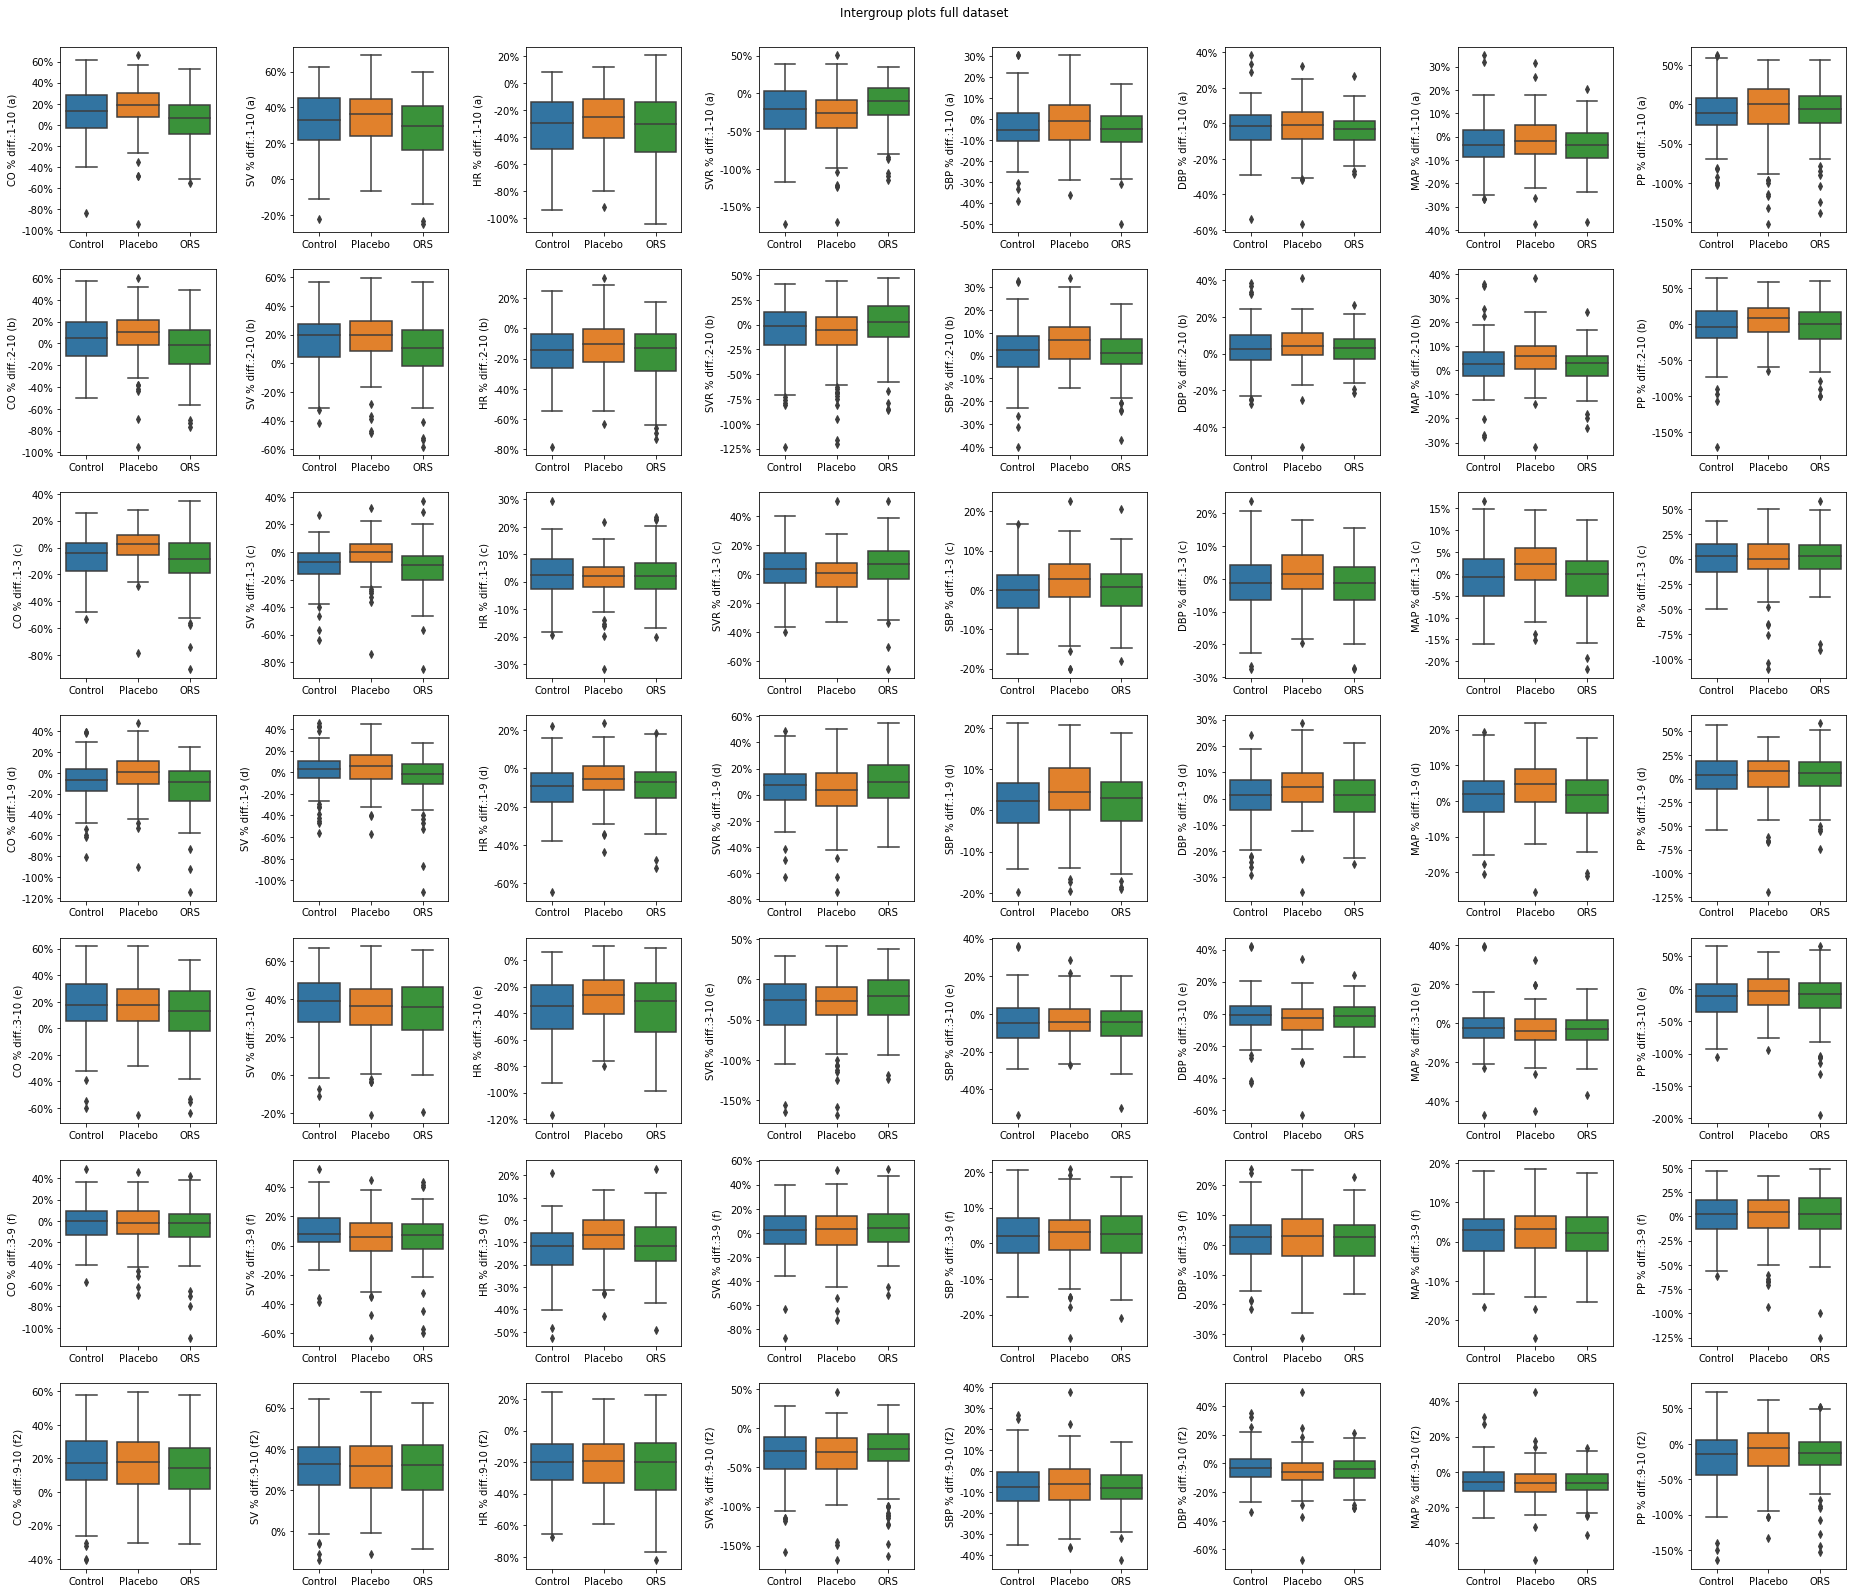

In [6]:
f,axes = plt.subplots(len(intergroups),len(HDparam),figsize=(4*len(HDparam),4*len(intergroups)))
for param in HDparam:
    r=0
    Event = [e+param for e in eventnames]
    for i in intergroups.keys():
        (a,b) = intergroups[i]
        tmp = pd.DataFrame(df.type)
        tmp['%s %% diff.:%d-%d (%s)'%(param,a,b,i)] = df.apply(lambda x: (x[Event[a-1]]-x[Event[b-1]])/x[Event[a-1]],axis=1)
        ax = sns.boxplot(y='%s %% diff.:%d-%d (%s)'%(param,a,b,i),x='type',data=tmp,ax=axes[r][HDparam.index(param)],order=['Control','Placebo','ORS'])
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
        ax.set_xlabel('')
        r+=1
plt.subplots_adjust(wspace=0.5)
plt.suptitle("Intergroup plots full dataset",y=0.9);

## Intragroups

In [7]:
res = pd.DataFrame(index = pd.MultiIndex.from_product([HDparam,types+['All']],names=['Parameter','Type']), columns = range(1,11))
res.head()
for param in HDparam:
    Event = [e+param for e in eventnames]
    for t in types+['All']:
        row = {}
        for e in range(1,11):
            if t == 'All':
                data = df[Event[e-1]]
                row[e] = "%.2f$\pm$%.2f"%(data.mean(), data.std())
            else:
                data = df[df.type==t][Event[e-1]]
                row[e] = "%.2f$\pm$%.2f"%(data.mean(), data.std())
        res.loc[(param,t)] = pd.Series(row) 
res.columns.name = 'Intragroup events ($\mu\pm\sigma$)'
display(res)

Intragroup events ($\mu\pm\sigma$)                  1                   2   \
Parameter Type                                                               
CO        Control                        4.14$\pm$0.87       3.82$\pm$1.00   
          Placebo                        4.14$\pm$0.89       3.80$\pm$1.02   
          ORS                            4.08$\pm$0.95       3.75$\pm$1.05   
          All                            4.12$\pm$0.91       3.79$\pm$1.02   
SV        Control                      62.42$\pm$13.16     50.30$\pm$13.52   
          Placebo                      61.75$\pm$12.03     49.83$\pm$13.54   
          ORS                          61.56$\pm$13.25     49.53$\pm$12.79   
          All                          61.91$\pm$12.80     49.89$\pm$13.26   
HR        Control                      67.19$\pm$10.55     77.09$\pm$11.74   
          Placebo                      67.70$\pm$11.01     77.26$\pm$11.89   
          ORS                          66.83$\pm$10.25     76.29$\pm$11.50   
          All                          67.24$\pm$10.59     76.88$\pm$11.69   
SVR       Control                   1825.79$\pm$392.77  2154.77$\pm$610.11   
          Placebo                   1819.28$\pm$434.47  2197.42$\pm$818.11   
          ORS                       1873.82$\pm$487.68  2210.20$\pm$640.98   
          All                       1839.52$\pm$439.45  2187.33$\pm$694.51   
SBP       Control                     117.90$\pm$11.91    125.47$\pm$13.58   
          Placebo                     116.74$\pm$13.39    125.50$\pm$15.40   
          ORS                         118.08$\pm$11.64    125.56$\pm$14.07   
          All                         117.57$\pm$12.32    125.51$\pm$14.34   
DBP       Control                       76.58$\pm$8.12      80.65$\pm$7.77   
          Placebo                       75.89$\pm$8.13      80.62$\pm$8.32   
          ORS                           76.04$\pm$7.75      80.63$\pm$7.68   
          All                           76.17$\pm$7.99      80.63$\pm$7.91   
MAP       Control                       90.35$\pm$8.62      95.59$\pm$8.71   
          Placebo                       89.51$\pm$9.12     95.58$\pm$10.03   
          ORS                           90.05$\pm$8.46      95.61$\pm$8.90   
          All                           89.97$\pm$8.72      95.59$\pm$9.21   
PP        Control                       41.33$\pm$8.71     44.83$\pm$10.79   
          Placebo                       40.85$\pm$9.65     44.88$\pm$10.54   
          ORS                           42.04$\pm$7.84     44.92$\pm$10.84   
          All                           41.40$\pm$8.76     44.88$\pm$10.70   

Intragroup events ($\mu\pm\sigma$)                  3                   4   \
Parameter Type                                                               
CO        Control                        4.38$\pm$0.87       5.10$\pm$1.09   
          Placebo                        4.10$\pm$0.97       4.81$\pm$1.25   
          ORS                            4.43$\pm$1.09       5.12$\pm$1.28   
          All                            4.31$\pm$0.99       5.01$\pm$1.22   
SV        Control                      68.08$\pm$14.18     75.74$\pm$15.50   
          Placebo                      62.20$\pm$12.61     70.29$\pm$16.38   
          ORS                          67.99$\pm$14.07     74.98$\pm$15.74   
          All                          66.09$\pm$13.88     73.67$\pm$16.02   
HR        Control                       65.29$\pm$9.38     68.01$\pm$10.05   
          Placebo                      66.43$\pm$10.10     68.88$\pm$10.58   
          ORS                          65.35$\pm$10.28     68.60$\pm$11.15   
          All                           65.69$\pm$9.91     68.49$\pm$10.58   
SVR       Control                   1729.04$\pm$382.43  1432.48$\pm$342.06   
          Placebo                   1805.27$\pm$457.60  1489.78$\pm$450.37   
          ORS                       1751.35$\pm$496.80  1442.02$\pm$413.37   
          All        

In [8]:
intragroups = dict(zip(['g','h','i','j','k','l','l2'],intergroups.values()))
res = pd.DataFrame(index = pd.MultiIndex.from_product([HDparam,types],names=['Parameter','Type']), columns = intragroups.keys())
for param in HDparam:
    Event = [e+param for e in eventnames]
    for i in intragroups.keys():
        (a,b) = intragroups[i]
        p_ = []
        for t in types:
            diffs = df[df.type==t].apply( lambda x: x[Event[a-1]]-x[Event[b-1]],axis=1)
            (H,p) = stats.wilcoxon(diffs.dropna())
            res.loc[(param,t),i] = p
res.columns = [": ".join(i) for i in zip(intragroups.keys(),eventnames)]
res.columns.name = 'Wilcoxon p-values for intragroups'
display(res)

Wilcoxon p-values for intragroups g: Prehy_sit_ h: Prehy_stand_  \
Parameter Type                                                    
CO        Control                         0.000           0.015   
          Placebo                         0.000           0.000   
          ORS                             0.002           0.339   
SV        Control                         0.000           0.000   
          Placebo                         0.000           0.000   
          ORS                             0.000           0.000   
HR        Control                         0.000           0.000   
          Placebo                         0.000           0.000   
          ORS                             0.000           0.000   
SVR       Control                         0.000           0.171   
          Placebo                         0.000           0.003   
          ORS                             0.000           0.181   
SBP       Control                         0.000           0.030   
          Placebo                         0.259           0.000   
          ORS                             0.000           0.064   
DBP       Control                         0.029           0.000   
          Placebo                         0.417           0.000   
          ORS                             0.000           0.001   
MAP       Control                         0.000           0.001   
          Placebo                         0.173           0.000   
          ORS                             0.000           0.001   
PP        Control                         0.000           0.776   
          Placebo                         0.704           0.001   
          ORS                             0.003           0.727   

Wilcoxon p-values for intragroups i: Posthy_sit_ j: Posthy_ss_  \
Parameter Type                                                   
CO        Control                          0.000         0.000   
          Placebo                          0.154         0.781   
          ORS                              0.000         0.000   
SV        Control                          0.000         0.040   
          Placebo                          0.803         0.000   
          ORS                              0.000         0.074   
HR        Control                          0.000         0.000   
          Placebo                          0.000         0.000   
          ORS                              0.002         0.000   
SVR       Control                          0.000         0.000   
          Placebo                          0.749         0.052   
          ORS                              0.000         0.000   
SBP       Control                          0.928         0.001   
          Placebo                          0.000         0.000   
          ORS                              0.720         0.000   
DBP       Control                          0.112         0.104   
          Placebo                          0.001         0.000   
          ORS                              0.093         0.378   
MAP       Control                          0.275         0.012   
          Placebo                          0.000         0.000   
          ORS                              0.357         0.016   
PP        Control                          0.141         0.012   
          Placebo                          0.106         0.004   
          ORS                              0.059         0.001   

Wilcoxon p-values for intragroups k: Posthy_0.5ss_ l: Posthy_1ss_  \
Parameter Type                                                      
CO        Control                            0.000          0.572   
          Placebo                            0.000          0.587   
          ORS                                0.000          0.052   
SV        Control                            0.000          0.000   
          Placebo                            0.000          0.000   
          ORS                                0.000       

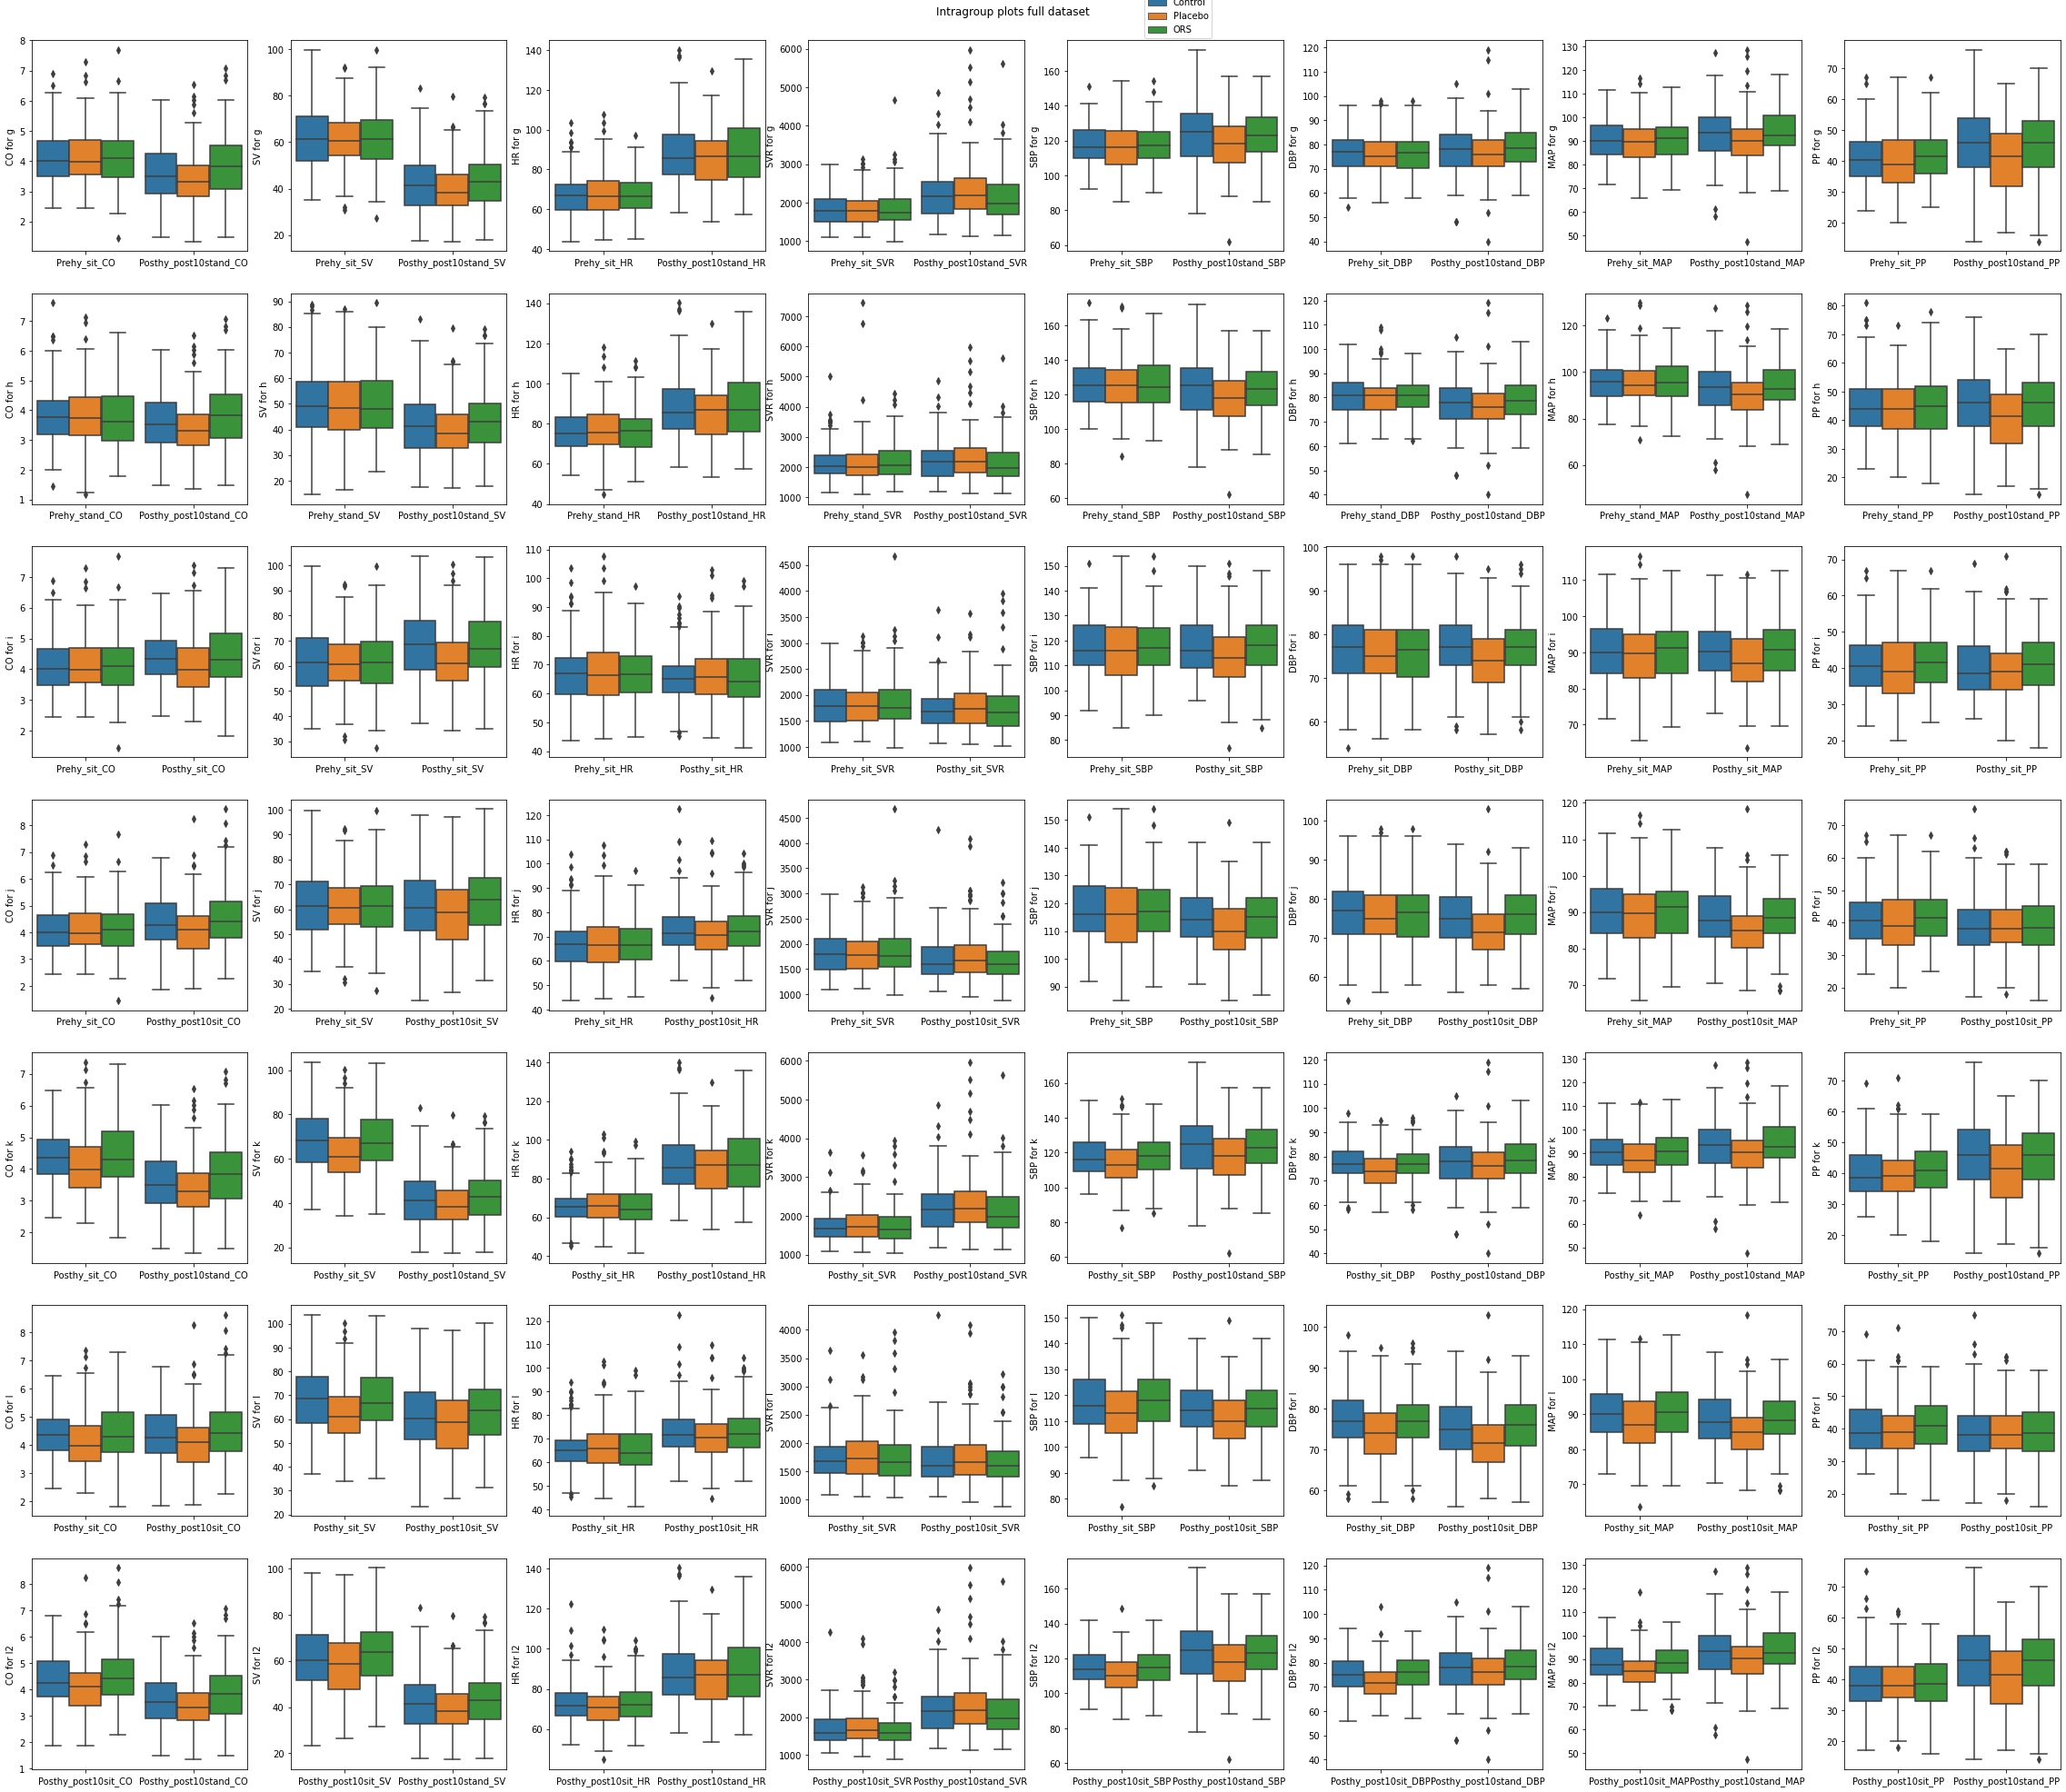

In [15]:
f,axes = plt.subplots(len(intragroups),len(HDparam),figsize=(5*len(HDparam),5*len(intragroups)))
for param in HDparam:
    r=0
    Event = [e+param for e in eventnames]
    for i in intragroups.keys():
        (a,b) = intragroups[i]
        tmp = pd.melt(df[['type',Event[a-1],Event[b-1]]],id_vars=['type'],value_vars=[Event[a-1],Event[b-1]],var_name='Event',value_name="%s for %s"%(param,i))
        ax = sns.boxplot(y="%s for %s"%(param,i),x='Event',data=tmp,hue='type',ax=axes[r][HDparam.index(param)],width=0.9,hue_order=['Control', 'Placebo','ORS'])
        ax.set_xlabel('')
        ax.legend_.remove()
        r+=1
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels, loc='upper center',bbox_to_anchor=[0.45,0.787]);
plt.subplots_adjust(wspace=0.2)
plt.suptitle("Intragroup plots full dataset",y=0.895);

# BDRI

,count,mean,std,min,max
BDRI_#1,429.000,0.196,0.658,0.000,5.000
BDRI_#2,429.000,0.245,0.679,0.000,5.000
BDRI_#3,429.000,0.527,0.836,0.000,5.000
BDRI_#4,429.000,0.154,0.493,0.000,4.000
BDRI_#5,429.000,0.110,0.478,0.000,5.000
BDRI_#6,429.000,0.068,0.359,0.000,4.000
BDRI_#7,429.000,0.336,0.680,0.000,4.000
BDRI_#8,429.000,0.436,0.788,0.000,4.000
BDRI_#9,429.000,0.103,0.442,0.000,4.000
BDRI_#10,429.000,0.145,0.461,0.000,3.000


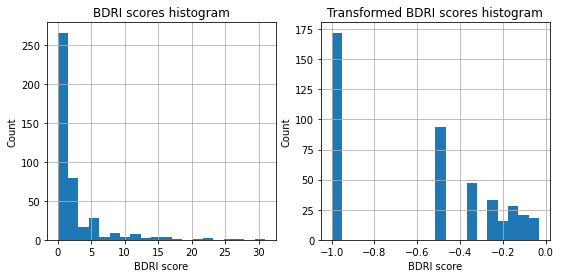

Shapiro-Wilk p-value for BDRI score = 9.29E-22
If p < 0.05, then reject null hypothesis that distribution is normally distributed


,BDRI_score
Control,3.0 $\pm$ 5.1 (n=144)
Placebo,1.8 $\pm$ 2.8 (n=143)
ORS,2.4 $\pm$ 4.3 (n=142)
KW p value,0.439
"(Control, Placebo)",0.654
"(Control, ORS)",1.000
"(Placebo, ORS)",1.000


In [16]:
display(df[BDRI_cols].describe().T[['count','mean','std','min','max']])

df['BDRI_score_trans'] = df['BDRI_score'].apply(lambda x: -1*(1/(x+1)))
smax,smin = df['BDRI_score_trans'].max(),df['BDRI_score_trans'].min()
nbins = 10
width = (smax-smin)/(nbins-1)
bins = [smin-0.5*width + a*width for a in range(10)]
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
df.BDRI_score.hist(bins=20)
plt.title('BDRI scores histogram')
plt.xlabel('BDRI score')
plt.ylabel('Count');
plt.subplot(1,2,2)
plt.hist(df['BDRI_score_trans'],bins=20);
plt.title('Transformed BDRI scores histogram');
plt.xlabel('BDRI score');
plt.ylabel('Count');
plt.grid()
plt.show()
(w,p) = stats.shapiro(df['BDRI_score_trans'])
print("Shapiro-Wilk p-value for BDRI score = %.2E"%p)
print("If p < 0.05, then reject null hypothesis that distribution is normally distributed")

pairs = list(itertools.combinations(types,2))
res = pd.DataFrame(index=['BDRI_score'],columns=types+['KW p value']+pairs)
data = [df[df.type==t]['BDRI_score'] for t in types]
stat,p_omni,z_pair,p_corr,_ = kw_dunn(data)
res.loc['BDRI_score',:] = ['%.1f $\pm$ %.1f (n=%d)'%(data[i].mean(),data[i].std(),data[i].count()) for i in range(len(data))]+\
                                [p_omni] + list(p_corr)
display(res.T)

In [17]:
df['VVR_none'] = df['VVR_occurrence'] == 'none'
categories = ['gender','donation_volume','donation_status','type','VVR_none']
for c in categories:
    table = pd.crosstab(df['BDRI_react'],df[c],margins=False).sort_values(axis=0,by='BDRI_react',ascending=False)
    table.columns.name += ' (n=%d)'%table.values.sum()
    display(table)
    display(contingency_analyse(table))
display(pd.crosstab(df['BDRI_react'],df.VVR_occurrence).sort_values(axis=0,by='BDRI_react',ascending=False))
for (a,b) in itertools.combinations(np.unique(df.VVR_occurrence),2):
    table = pd.crosstab(df['BDRI_react'],
                        df.VVR_occurrence[(df.VVR_occurrence == a)|(df.VVR_occurrence == b)],
                        margins=False).sort_values(axis=0,by='BDRI_react',ascending=False)
    table.columns.name += ' (n=%d)'%table.values.sum()
    display(table)
    if table.shape == (2,2) and table.values.min() != 0:
        display(contingency_analyse(table))

gender (n=429),female,male
BDRI_react,,
True,131,126
False,87,85


,Chi-squared correlation test
p value,0.985
odds ratio,1.016
CI on OR,"(0.69, 1.49)"


donation_volume (n=406),350ml,450ml
BDRI_react,,
True,85,155
False,59,107


,Chi-squared correlation test
p value,0.937
odds ratio,0.995
CI on OR,"(0.66, 1.50)"


donation_status (n=429),first time,repeated
BDRI_react,,
True,50,207
False,38,134


,Chi-squared correlation test
p value,0.588
odds ratio,0.852
CI on OR,"(0.53, 1.37)"


type (n=429),Control,ORS,Placebo
BDRI_react,,,
True,92,82,83
False,52,60,60


,Chi-squared correlation test
p value,0.488


VVR_none (n=429),False,True
BDRI_react,,
True,45,212
False,6,166


,Chi-squared correlation test
p value,0.000
odds ratio,5.873
CI on OR,"(2.45, 14.10)"


VVR_occurrence,delayed,immediate_or_both,none
BDRI_react,,,
True,34,11,212
False,6,0,166


VVR_occurrence (n=51),delayed,immediate_or_both
BDRI_react,,
True,34,11
False,6,0


VVR_occurrence (n=418),delayed,none
BDRI_react,,
True,34,212
False,6,166


,Chi-squared correlation test
p value,0.001
odds ratio,4.437
CI on OR,"(1.82, 10.82)"


VVR_occurrence (n=389),immediate_or_both,none
BDRI_react,,
True,11,212
False,0,166


,BDRI react = True,BDRI_react = False,Mann-Whitney p-value
Prehy_stand_CO,3.9 $\pm$ 1.0,3.7 $\pm$ 1.0,0.051
Prehy_stand_SV,50.3 $\pm$ 13.1,49.2 $\pm$ 13.5,0.122
Prehy_stand_HR,77.5 $\pm$ 11.5,76.0 $\pm$ 12.0,0.141
Prehy_stand_SVR,2146.8 $\pm$ 683.2,2247.9 $\pm$ 708.8,0.043
Prehy_stand_SBP,125.4 $\pm$ 14.5,125.6 $\pm$ 14.2,0.421
Prehy_stand_DBP,80.5 $\pm$ 7.9,80.8 $\pm$ 8.0,0.388
Prehy_stand_MAP,95.5 $\pm$ 9.2,95.8 $\pm$ 9.2,0.381
Prehy_stand_PP,44.9 $\pm$ 10.8,44.8 $\pm$ 10.5,0.351


,BDRI react = True,BDRI_react = False,Mann-Whitney p-value
Posthy_post10stand_CO,3.7 $\pm$ 1.0,3.5 $\pm$ 1.0,0.045
Posthy_post10stand_SV,42.7 $\pm$ 12.3,41.2 $\pm$ 11.7,0.054
Posthy_post10stand_HR,87.4 $\pm$ 15.7,87.2 $\pm$ 15.2,0.330
Posthy_post10stand_SVR,2198.6 $\pm$ 723.5,2298.2 $\pm$ 729.4,0.133
Posthy_post10stand_SBP,121.2 $\pm$ 15.8,122.4 $\pm$ 15.4,0.363
Posthy_post10stand_DBP,77.5 $\pm$ 9.2,78.0 $\pm$ 9.2,0.334
Posthy_post10stand_MAP,92.1 $\pm$ 10.5,92.8 $\pm$ 10.2,0.476
Posthy_post10stand_PP,43.7 $\pm$ 11.8,44.4 $\pm$ 12.1,0.376


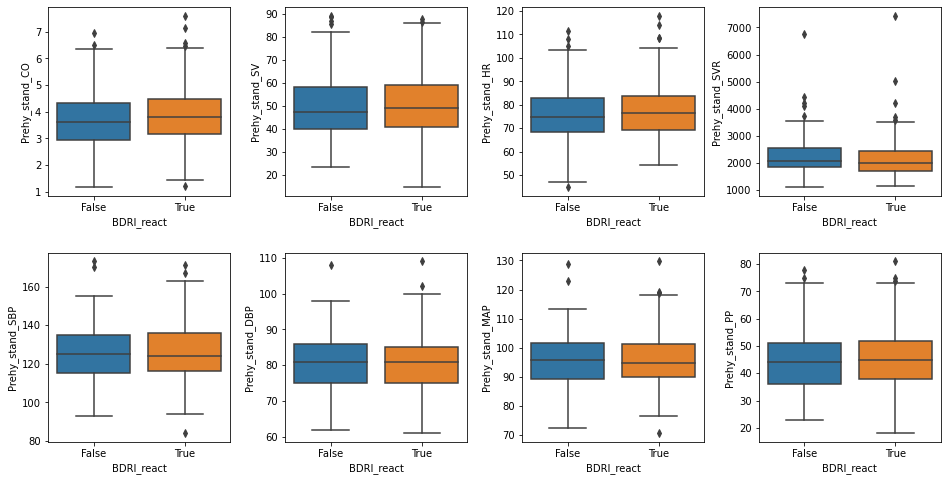

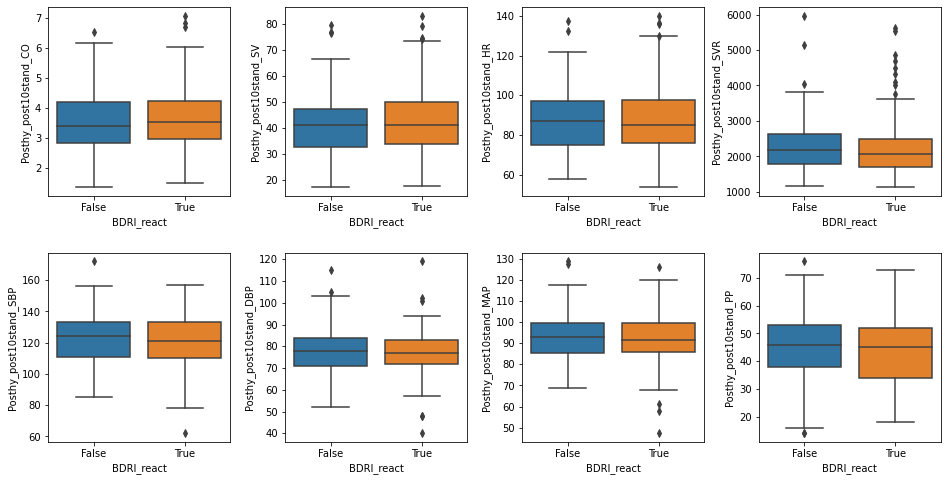

In [18]:
keyvars = ['Prehy_stand_CO','Prehy_stand_SV','Prehy_stand_HR','Prehy_stand_SVR','Prehy_stand_SBP','Prehy_stand_DBP','Prehy_stand_MAP','Prehy_stand_PP']
res = pd.DataFrame(index=keyvars,columns=["BDRI react = True", "BDRI_react = False","Mann-Whitney p-value"])
for k in keyvars:
    a,b = df[df['BDRI_react']==True][k],df[df['BDRI_react']==False][k]
    MW,p = stats.mannwhitneyu(a,b)
    res.loc[k] = ["%.1f $\pm$ %.1f"%(a.mean(), a.std()),"%.1f $\pm$ %.1f"%(b.mean(), b.std()),p]
display(res)

f, axes = plt.subplots(2,4,figsize=(16,8));
for p in range(8):
    g = sns.boxplot(x='BDRI_react',y=keyvars[p],data=df,ax=axes[int(p>3)][p%4])
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

keyvars = ['Posthy_post10stand_CO','Posthy_post10stand_SV','Posthy_post10stand_HR','Posthy_post10stand_SVR','Posthy_post10stand_SBP','Posthy_post10stand_DBP','Posthy_post10stand_MAP','Posthy_post10stand_PP']
res = pd.DataFrame(index=keyvars,columns=["BDRI react = True", "BDRI_react = False","Mann-Whitney p-value"])
for k in keyvars:
    a,b = df[df['BDRI_react']==True][k],df[df['BDRI_react']==False][k]
    MW,p = stats.mannwhitneyu(a,b)
    res.loc[k] = ["%.1f $\pm$ %.1f"%(a.mean(), a.std()),"%.1f $\pm$ %.1f"%(b.mean(), b.std()),p]
display(res)
f, axes = plt.subplots(2,4,figsize=(16,8));
for p in range(8):
    g = sns.boxplot(x='BDRI_react',y=keyvars[p],data=df,ax=axes[int(p>3)][p%4])
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

In [19]:
keyvars = ['donation_percent','age','height']
res = pd.DataFrame(index=keyvars,columns=["BDRI react = True", "BDRI_react = False","Mann-Whitney p-value"])
for k in keyvars:
    a,b = df[df['BDRI_react']==True][k],df[df['BDRI_react']==False][k]
    MW,p = stats.mannwhitneyu(a,b)
    res.loc[k] = ["%.1f $\pm$ %.1f (n=%d)"%(a.mean(), a.std(),a.count()),"%.1f $\pm$ %.1f (n=%d)"%(b.mean(), b.std(),b.count()),p]
res

,BDRI react = True,BDRI_react = False,Mann-Whitney p-value
donation_percent,10.3 $\pm$ 1.7 (n=257),10.3 $\pm$ 1.8 (n=172),0.434
age,19.6 $\pm$ 2.1 (n=257),19.7 $\pm$ 1.6 (n=172),0.496
height,167.0 $\pm$ 8.1 (n=257),167.0 $\pm$ 9.2 (n=172),0.480


Posthy_ss_DBP by BDRI_react


,mean,std,min,max
,Posthy_ss_DBP,Posthy_ss_DBP,Posthy_ss_DBP,Posthy_ss_DBP
BDRI_react,,,,
False,72.965,7.871,55,94
True,72.370,7.706,51,90


Mann-Whitney U test for Posthy_ss_SBP distributions by BDRI_react:
p-value = 0.278


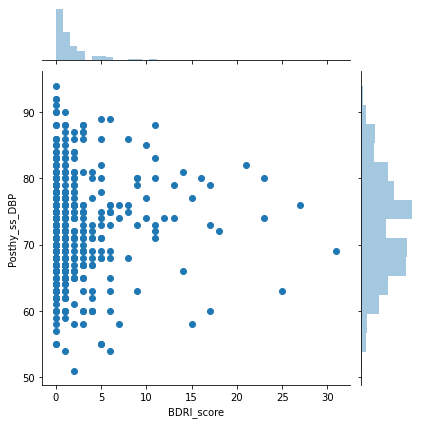

In [20]:
sns.jointplot(data=df,x='BDRI_score',y='Posthy_ss_DBP')
print('Posthy_ss_DBP by BDRI_react')
display(pd.pivot_table(data=df,values='Posthy_ss_DBP',index='BDRI_react',aggfunc=['mean','std','min','max']))
import scipy.stats as stats
w,p = stats.mannwhitneyu(df[df.BDRI_react==True]['Posthy_ss_DBP'],df[df.BDRI_react==False]['Posthy_ss_DBP'])
print("Mann-Whitney U test for Posthy_ss_SBP distributions by BDRI_react:\np-value = %.3f"%p)

In [21]:
res = pd.DataFrame(index = HDparam, columns = pd.MultiIndex.from_product([intergroups.keys(),['BDRI react True','BDRI react False','MWU p value']]))
for param in HDparam:
    Event = [e+param for e in eventnames]
    for i in intergroups.keys():
        (a,b) = intergroups[i]
        t, f = [((df[df.BDRI_react==t][Event[a-1]]-df[df.BDRI_react==t][Event[b-1]])/df[df.BDRI_react==t][Event[a-1]]) for t in [True,False]]
        (H,p) = stats.mannwhitneyu(t,f)
        res.loc[param,i] = ["%.1f $\pm$ %.1f"%(t.mean(), t.std()),"%.1f $\pm$ %.1f"%(f.mean(), f.std()),p]
res.index.name = "MANN-WHITNEY U TEST FOR BDRI_react"
display(res)

res = pd.DataFrame(index=BDRI_cols,columns=['VVR_any True', 'VVR_any False','p-value'])
for b in BDRI_cols:
    t,f = df[df.VVR_any==True][b],df[df.VVR_any==False][b]
    stat,p = stats.mannwhitneyu(t,f)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(), t.count()),"%.1f $\pm$ %.1f (n=%d)"%(f.mean(), f.std(),f.count()),p]
res.index.name = 'Mann Whitney U test on BDRI_questions'
display(res)

vvrs = list(np.unique(df.VVR_occurrence))
pairs = [" - ".join(pair) for pair in itertools.combinations(vvrs,2)]
res = pd.DataFrame(index=BDRI_cols,columns=vvrs+['Kruskal Wallis p-value']+pairs)
for b in BDRI_cols:
    data = [df.groupby('VVR_occurrence').get_group(v)[b] for v in vvrs]
    stat,p_omni,z_pairs,p_corr,_ = kw_dunn(data)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(),t.count()) for t in data]+[p_omni]+[p_corr[i] for i in range(len(pairs))]
display(res)

a                   \
                                   BDRI react True BDRI react False   
MANN-WHITNEY U TEST FOR BDRI_react                                    
CO                                   0.1 $\pm$ 0.2    0.1 $\pm$ 0.2   
SV                                   0.3 $\pm$ 0.2    0.3 $\pm$ 0.2   
HR                                  -0.3 $\pm$ 0.2   -0.3 $\pm$ 0.2   
SVR                                 -0.3 $\pm$ 0.3   -0.2 $\pm$ 0.3   
SBP                                 -0.0 $\pm$ 0.1   -0.0 $\pm$ 0.1   
DBP                                 -0.0 $\pm$ 0.1   -0.0 $\pm$ 0.1   
MAP                                 -0.0 $\pm$ 0.1   -0.0 $\pm$ 0.1   
PP                                  -0.1 $\pm$ 0.3   -0.1 $\pm$ 0.3   

                                                             b  \
                                   MWU p value BDRI react True   
MANN-WHITNEY U TEST FOR BDRI_react                               
CO                                       0.042   0.0 $\pm$ 0.2   
SV                                       0.065   0.1 $\pm$ 0.2   
HR                                       0.289  -0.1 $\pm$ 0.2   
SVR                                      0.248  -0.1 $\pm$ 0.3   
SBP                                      0.243   0.0 $\pm$ 0.1   
DBP                                      0.359   0.0 $\pm$ 0.1   
MAP                                      0.383   0.0 $\pm$ 0.1   
PP                                       0.167  -0.0 $\pm$ 0.3   

                                                                 \
                                   BDRI react False MWU p value   
MANN-WHITNEY U TEST FOR BDRI_react                                
CO                                    0.0 $\pm$ 0.2       0.114   
SV                                    0.1 $\pm$ 0.2       0.244   
HR                                   -0.2 $\pm$ 0.2       0.064   
SVR                                  -0.1 $\pm$ 0.3       0.403   
SBP                                   0.0 $\pm$ 0.1       0.147   
DBP                                   0.0 $\pm$ 0.1       0.429   
MAP                                   0.0 $\pm$ 0.1       0.289   
PP                                   -0.0 $\pm$ 0.3       0.176   

                                                 c                   \
                                   BDRI react True BDRI react False   
MANN-WHITNEY U TEST FOR BDRI_react                                    
CO                                  -0.0 $\pm$ 0.2   -0.1 $\pm$ 0.2   
SV                                  -0.1 $\pm$ 0.1   -0.1 $\pm$ 0.2   
HR                                   0.0 $\pm$ 0.1    0.0 $\pm$ 0.1   
SVR                                  0.0 $\pm$ 0.1    0.0 $\pm$ 0.2   
SBP                                  0.0 $\pm$ 0.1    0.0 $\pm$ 0.1   
DBP                                 -0.0 $\pm$ 0.1    0.0 $\pm$ 0.1   
MAP                                 -0.0 $\pm$ 0.1    0.0 $\pm$ 0.1   
PP                                   0.0 $\pm$ 0.2    0.0 $\pm$ 0.2   

                                                             d  \
                                   MWU p value BDRI react True   
MANN-WHITNEY U TEST FOR BDRI_react                               
CO                                       0.201  -0.1 $\pm$ 0.2   
SV                                       0.319   0.0 $\pm$ 0.2   
HR                                       0.312  -0.1 $\pm$ 0.1   
SVR                                      0.027   0.0 $\pm$ 0.2   
SBP                                      0.029   0.0 $\pm$ 0.1   
DBP                                      0.016   0.0 $\pm$ 0.1   
MAP                                      0.005   0.0 $\pm$ 0.1   
PP                                       0.119   0.0 $\pm$ 0.2   

                                                                 \
                                   BDRI react False MWU p value   
MANN-WHITNEY U TEST FOR BDRI_react                                
CO                                   -0.1 $\pm$ 0.2       0.034   
SV                       

,VVR_any True,VVR_any False,p-value
Mann Whitney U test on BDRI_questions,,,
BDRI_#1,0.9 $\pm$ 1.5 (n=51),0.1 $\pm$ 0.3 (n=378),0.000
BDRI_#2,0.9 $\pm$ 1.4 (n=51),0.2 $\pm$ 0.5 (n=378),0.000
BDRI_#3,1.2 $\pm$ 1.3 (n=51),0.4 $\pm$ 0.7 (n=378),0.000
BDRI_#4,0.4 $\pm$ 0.7 (n=51),0.1 $\pm$ 0.4 (n=378),0.001
BDRI_#5,0.4 $\pm$ 1.1 (n=51),0.1 $\pm$ 0.3 (n=378),0.005
BDRI_#6,0.2 $\pm$ 0.7 (n=51),0.0 $\pm$ 0.3 (n=378),0.001
BDRI_#7,0.7 $\pm$ 1.0 (n=51),0.3 $\pm$ 0.6 (n=378),0.000
BDRI_#8,0.7 $\pm$ 0.9 (n=51),0.4 $\pm$ 0.8 (n=378),0.007
BDRI_#9,0.4 $\pm$ 0.9 (n=51),0.1 $\pm$ 0.3 (n=378),0.000


,delayed,immediate_or_both,none,Kruskal Wallis p-value,delayed - immediate_or_both,delayed - none,immediate_or_both - none
BDRI_#1,0.3 $\pm$ 0.6 (n=40),3.2 $\pm$ 1.5 (n=11),0.1 $\pm$ 0.3 (n=378),0.000,0.000,0.233,0.000
BDRI_#2,0.4 $\pm$ 0.6 (n=40),2.8 $\pm$ 1.6 (n=11),0.2 $\pm$ 0.5 (n=378),0.000,0.001,0.200,0.000
BDRI_#3,0.8 $\pm$ 0.9 (n=40),2.6 $\pm$ 1.4 (n=11),0.4 $\pm$ 0.7 (n=378),0.000,0.009,0.040,0.000
BDRI_#4,0.2 $\pm$ 0.4 (n=40),1.0 $\pm$ 1.3 (n=11),0.1 $\pm$ 0.4 (n=378),0.000,0.334,1.000,0.084
BDRI_#5,0.1 $\pm$ 0.3 (n=40),1.5 $\pm$ 2.0 (n=11),0.1 $\pm$ 0.3 (n=378),0.000,0.125,1.000,0.058
BDRI_#6,0.1 $\pm$ 0.3 (n=40),0.8 $\pm$ 1.4 (n=11),0.0 $\pm$ 0.3 (n=378),0.000,0.402,1.000,0.175
BDRI_#7,0.6 $\pm$ 0.8 (n=40),1.2 $\pm$ 1.3 (n=11),0.3 $\pm$ 0.6 (n=378),0.000,0.620,0.099,0.031
BDRI_#8,0.7 $\pm$ 0.9 (n=40),0.8 $\pm$ 0.9 (n=11),0.4 $\pm$ 0.8 (n=378),0.030,1.000,0.433,0.312
BDRI_#9,0.2 $\pm$ 0.5 (n=40),1.4 $\pm$ 1.5 (n=11),0.1 $\pm$ 0.3 (n=378),0.000,0.024,1.000,0.002
BDRI_#10,0.2 $\pm$ 0.5 (n=40),1.0 $\pm$ 1.2 (n=11),0.1 $\pm$ 0.4 (n=378),0.000,0.330,1.000,0.071


# TQ Scores

,count,mean,std,min,max
TQ#1,425.000,0.144,0.652,0.000,5.000
TQ#2,425.000,0.306,0.765,0.000,5.000
TQ#3,425.000,0.520,0.934,0.000,5.000
TQ#4,425.000,0.099,0.394,0.000,4.000
TQ#5,425.000,0.118,0.496,0.000,5.000
TQ#6,425.000,0.061,0.338,0.000,3.000
TQ#7,425.000,0.311,0.738,0.000,5.000
TQ#8,425.000,0.233,0.637,0.000,4.000
TQ#9,425.000,0.151,0.634,0.000,5.000
TQ#10,425.000,0.136,0.510,0.000,4.000


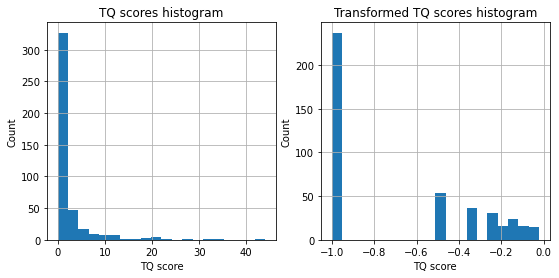

Shapiro-Wilk p-value for TQ score = 4.39E-25
If p < 0.05, then reject null hypothesis that distribution is normally distributed


,TQ_score
Control,2.4 $\pm$ 6.0 (n=144)
Placebo,2.3 $\pm$ 4.9 (n=143)
ORS,2.0 $\pm$ 4.1 (n=142)
KW p value,0.442
"(Control, Placebo)",0.822
"(Control, ORS)",1.000
"(Placebo, ORS)",1.000


In [22]:
display(df[TQ_cols].describe().T[['count','mean','std','min','max']])

df['TQ_score_trans'] = df['TQ_score'].apply(lambda x: -1*(1/(x+1)))
smax,smin = df['TQ_score_trans'].max(),df['TQ_score_trans'].min()
nbins = 10
width = (smax-smin)/(nbins-1)
bins = [smin-0.5*width + a*width for a in range(10)]
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
df.TQ_score.hist(bins=20)
plt.title('TQ scores histogram')
plt.xlabel('TQ score')
plt.ylabel('Count');
plt.subplot(1,2,2)
plt.hist(df['TQ_score_trans'],bins=20);
plt.title('Transformed TQ scores histogram');
plt.xlabel('TQ score');
plt.ylabel('Count');
plt.grid()
plt.show()
(w,p) = stats.shapiro(df['TQ_score_trans'])
print("Shapiro-Wilk p-value for TQ score = %.2E"%p)
print("If p < 0.05, then reject null hypothesis that distribution is normally distributed")

pairs = list(itertools.combinations(types,2))
res = pd.DataFrame(index=['TQ_score'],columns=types+['KW p value']+pairs)
data = [df[df.type==t]['TQ_score'] for t in types]
stat,p_omni,z_pair,p_corr,_ = kw_dunn(data)
res.loc['TQ_score',:] = ['%.1f $\pm$ %.1f (n=%d)'%(data[i].mean(),data[i].std(),data[i].count()) for i in range(len(data))]+\
                                [p_omni] + list(p_corr)
display(res.T)



In [23]:
df['VVR_none'] = df['VVR_occurrence'] == 'none'
categories = ['gender','donation_volume','donation_status','type','VVR_none']
for c in categories:
    table = pd.crosstab(df['TQ_react'],df[c],margins=False).sort_values(axis=0,by='TQ_react',ascending=False)
    table.columns.name += ' (n=%d)'%table.values.sum()
    display(table)
    display(contingency_analyse(table))
display(pd.crosstab(df['TQ_react'],df.VVR_occurrence).sort_values(axis=0,by='TQ_react',ascending=False))
for (a,b) in itertools.combinations(np.unique(df.VVR_occurrence),2):
    table = pd.crosstab(df['TQ_react'],
                        df.VVR_occurrence[(df.VVR_occurrence == a)|(df.VVR_occurrence == b)],
                        margins=False).sort_values(axis=0,by='TQ_react',ascending=False)
    table.columns.name += ' (n=%d)'%table.values.sum()
    display(table)
    if table.shape == (2,2) and table.values.min() != 0:
        display(contingency_analyse(table))

gender (n=429),female,male
TQ_react,,
True,98,94
False,120,117


,Chi-squared correlation test
p value,0.990
odds ratio,1.016
CI on OR,"(0.69, 1.49)"


donation_volume (n=406),350ml,450ml
TQ_react,,
True,60,120
False,84,142


,Chi-squared correlation test
p value,0.485
odds ratio,0.845
CI on OR,"(0.56, 1.27)"


donation_status (n=429),first time,repeated
TQ_react,,
True,37,155
False,51,186


,Chi-squared correlation test
p value,0.650
odds ratio,0.871
CI on OR,"(0.54, 1.40)"


type (n=429),Control,ORS,Placebo
TQ_react,,,
True,57,67,68
False,87,75,75


,Chi-squared correlation test
p value,0.309


VVR_none (n=429),False,True
TQ_react,,
True,44,148
False,7,230


,Chi-squared correlation test
p value,0.000
odds ratio,9.768
CI on OR,"(4.29, 22.26)"


VVR_occurrence,delayed,immediate_or_both,none
TQ_react,,,
True,36,8,148
False,4,3,230


VVR_occurrence (n=51),delayed,immediate_or_both
TQ_react,,
True,36,8
False,4,3


,Fisher Exact Test (small sample size)
p value,0.162
odds ratio,3.375
CI on OR,"(0.63, 18.14)"


VVR_occurrence (n=418),delayed,none
TQ_react,,
True,36,148
False,4,230


,Fisher Exact Test (small sample size)
p value,0.000
odds ratio,13.986
CI on OR,"(4.88, 40.11)"


VVR_occurrence (n=389),immediate_or_both,none
TQ_react,,
True,8,148
False,3,230


,Fisher Exact Test (small sample size)
p value,0.031
odds ratio,4.144
CI on OR,"(1.08, 15.87)"


,TQ react = True,TQ_react = False,Mann-Whitney p-value
Prehy_stand_CO,3.8 $\pm$ 1.1,3.8 $\pm$ 1.0,0.330
Prehy_stand_SV,50.0 $\pm$ 13.5,49.8 $\pm$ 13.1,0.409
Prehy_stand_HR,76.5 $\pm$ 11.6,77.2 $\pm$ 11.8,0.308
Prehy_stand_SVR,2182.5 $\pm$ 728.9,2191.3 $\pm$ 666.9,0.446
Prehy_stand_SBP,124.2 $\pm$ 14.3,126.6 $\pm$ 14.3,0.057
Prehy_stand_DBP,80.2 $\pm$ 8.0,81.0 $\pm$ 7.8,0.183
Prehy_stand_MAP,94.9 $\pm$ 9.4,96.2 $\pm$ 9.0,0.062
Prehy_stand_PP,44.0 $\pm$ 10.1,45.6 $\pm$ 11.1,0.094


,TQ react = True,TQ_react = False,Mann-Whitney p-value
Posthy_post10stand_CO,3.7 $\pm$ 1.0,3.5 $\pm$ 1.0,0.061
Posthy_post10stand_SV,43.0 $\pm$ 12.7,41.3 $\pm$ 11.5,0.092
Posthy_post10stand_HR,87.5 $\pm$ 16.0,87.1 $\pm$ 15.1,0.305
Posthy_post10stand_SVR,2162.2 $\pm$ 707.2,2300.3 $\pm$ 737.6,0.035
Posthy_post10stand_SBP,119.6 $\pm$ 16.1,123.3 $\pm$ 15.1,0.033
Posthy_post10stand_DBP,77.2 $\pm$ 9.5,78.1 $\pm$ 9.0,0.456
Posthy_post10stand_MAP,91.3 $\pm$ 10.8,93.2 $\pm$ 9.9,0.143
Posthy_post10stand_PP,42.4 $\pm$ 11.4,45.2 $\pm$ 12.1,0.032


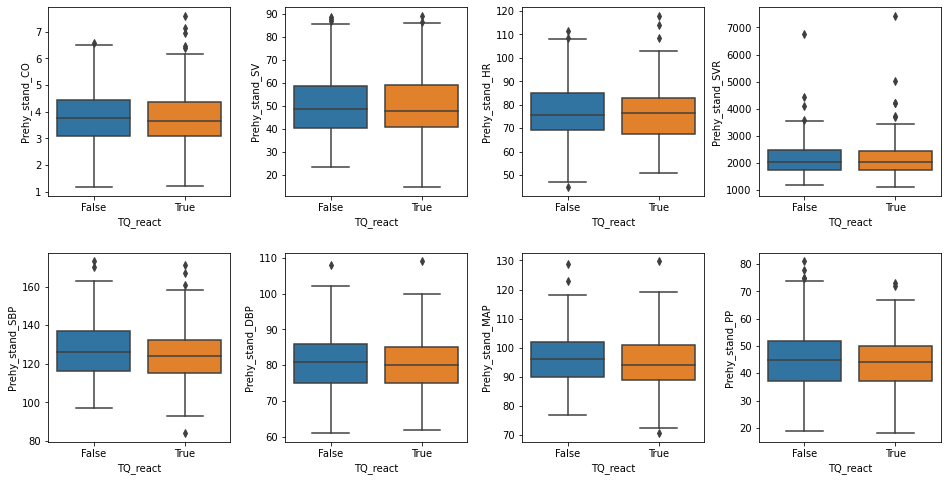

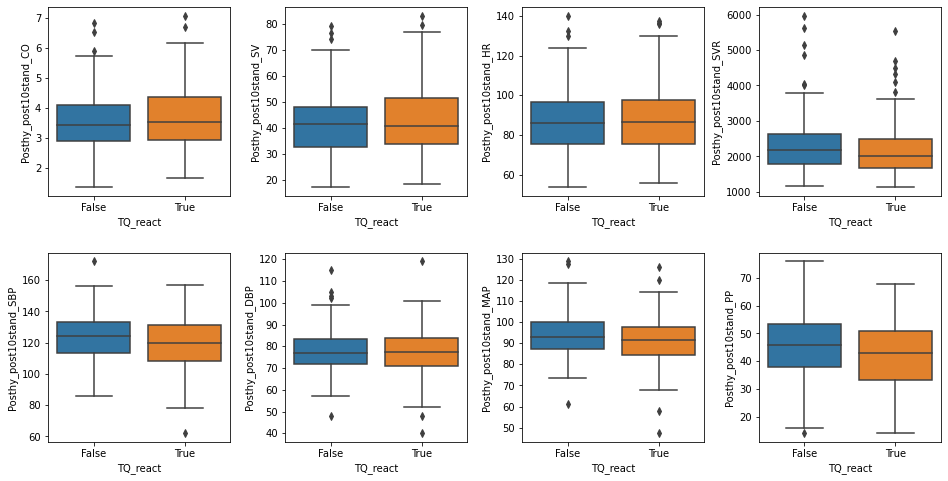

In [24]:
keyvars = ['Prehy_stand_CO','Prehy_stand_SV','Prehy_stand_HR','Prehy_stand_SVR','Prehy_stand_SBP','Prehy_stand_DBP','Prehy_stand_MAP','Prehy_stand_PP']
res = pd.DataFrame(index=keyvars,columns=["TQ react = True", "TQ_react = False","Mann-Whitney p-value"])
for k in keyvars:
    a,b = df[df['TQ_react']==True][k],df[df['TQ_react']==False][k]
    MW,p = stats.mannwhitneyu(a,b)
    res.loc[k] = ["%.1f $\pm$ %.1f"%(a.mean(), a.std()),"%.1f $\pm$ %.1f"%(b.mean(), b.std()),p]
display(res)

f, axes = plt.subplots(2,4,figsize=(16,8));
for p in range(8):
    g = sns.boxplot(x='TQ_react',y=keyvars[p],data=df,ax=axes[int(p>3)][p%4])
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

keyvars = ['Posthy_post10stand_CO','Posthy_post10stand_SV','Posthy_post10stand_HR','Posthy_post10stand_SVR','Posthy_post10stand_SBP','Posthy_post10stand_DBP','Posthy_post10stand_MAP','Posthy_post10stand_PP']
res = pd.DataFrame(index=keyvars,columns=["TQ react = True", "TQ_react = False","Mann-Whitney p-value"])
for k in keyvars:
    a,b = df[df['TQ_react']==True][k],df[df['TQ_react']==False][k]
    MW,p = stats.mannwhitneyu(a,b)
    res.loc[k] = ["%.1f $\pm$ %.1f"%(a.mean(), a.std()),"%.1f $\pm$ %.1f"%(b.mean(), b.std()),p]
display(res)
f, axes = plt.subplots(2,4,figsize=(16,8));
for p in range(8):
    g = sns.boxplot(x='TQ_react',y=keyvars[p],data=df,ax=axes[int(p>3)][p%4])
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.3)

In [25]:
keyvars = ['donation_percent','age','height']
res = pd.DataFrame(index=keyvars,columns=["TQ react = True", "TQ_react = False","Mann-Whitney p-value"])
for k in keyvars:
    a,b = df[df['TQ_react']==True][k],df[df['TQ_react']==False][k]
    MW,p = stats.mannwhitneyu(a,b)
    res.loc[k] = ["%.1f $\pm$ %.1f (n=%d)"%(a.mean(), a.std(),a.count()),"%.1f $\pm$ %.1f (n=%d)"%(b.mean(), b.std(),b.count()),p]
res

,TQ react = True,TQ_react = False,Mann-Whitney p-value
donation_percent,10.3 $\pm$ 1.9 (n=192),10.3 $\pm$ 1.7 (n=237),0.492
age,19.7 $\pm$ 1.7 (n=192),19.7 $\pm$ 2.1 (n=237),0.333
height,167.4 $\pm$ 8.6 (n=192),166.7 $\pm$ 8.5 (n=237),0.230


Posthy_ss_DBP by TQ_react


,mean,std,min,max
,Posthy_ss_DBP,Posthy_ss_DBP,Posthy_ss_DBP,Posthy_ss_DBP
TQ_react,,,,
False,72.857,8.009,51,92
True,72.302,7.471,54,94


Mann-Whitney U test for Posthy_ss_SBP distributions by TQ_react:
p-value = 0.291


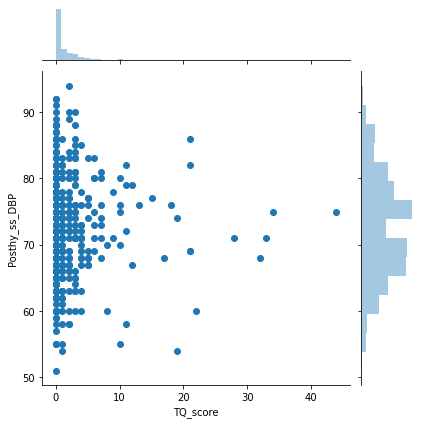

In [26]:
sns.jointplot(data=df,x='TQ_score',y='Posthy_ss_DBP')
print('Posthy_ss_DBP by TQ_react')
display(pd.pivot_table(data=df,values='Posthy_ss_DBP',index='TQ_react',aggfunc=['mean','std','min','max']))
import scipy.stats as stats
w,p = stats.mannwhitneyu(df[df.TQ_react==True]['Posthy_ss_DBP'],df[df.TQ_react==False]['Posthy_ss_DBP'])
print("Mann-Whitney U test for Posthy_ss_SBP distributions by TQ_react:\np-value = %.3f"%p)

In [27]:
res = pd.DataFrame(index = HDparam, columns = pd.MultiIndex.from_product([intergroups.keys(),['TQ react True','TQ react False','MWU p value']]))
for param in HDparam:
    Event = [e+param for e in eventnames]
    for i in intergroups.keys():
        (a,b) = intergroups[i]
        t, f = [((df[df.TQ_react==t][Event[a-1]]-df[df.TQ_react==t][Event[b-1]])/df[df.TQ_react==t][Event[a-1]]) for t in [True,False]]
        (H,p) = stats.mannwhitneyu(t,f)
        res.loc[param,i] = ["%.1f $\pm$ %.1f"%(t.mean(), t.std()),"%.1f $\pm$ %.1f"%(f.mean(), f.std()),p]
res.index.name = "MANN-WHITNEY U TEST FOR TQ_react"
display(res)

res = pd.DataFrame(index=TQ_cols,columns=['VVR_any True', 'VVR_any False','p-value'])
for b in TQ_cols:
    t,f = df[df.VVR_any==True][b],df[df.VVR_any==False][b]
    stat,p = stats.mannwhitneyu(t,f)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(), t.count()),"%.1f $\pm$ %.1f (n=%d)"%(f.mean(), f.std(),f.count()),p]
res.index.name = 'Mann Whitney U test on TQ_questions'
display(res)

vvrs = list(np.unique(df.VVR_occurrence))
pairs = [" - ".join(pair) for pair in itertools.combinations(vvrs,2)]
res = pd.DataFrame(index=TQ_cols,columns=vvrs+['Kruskal Wallis p-value']+pairs)
for b in TQ_cols:
    data = [df.groupby('VVR_occurrence').get_group(v)[b] for v in vvrs]
    stat,p_omni,z_pairs,p_corr,_ = kw_dunn(data)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(),t.count()) for t in data]+[p_omni]+[p_corr[i] for i in range(len(pairs))]
display(res)

a                              \
                                   TQ react True  TQ react False MWU p value   
MANN-WHITNEY U TEST FOR TQ_react                                               
CO                                 0.1 $\pm$ 0.2   0.1 $\pm$ 0.2       0.250   
SV                                 0.3 $\pm$ 0.2   0.3 $\pm$ 0.2       0.439   
HR                                -0.3 $\pm$ 0.2  -0.3 $\pm$ 0.2       0.223   
SVR                               -0.2 $\pm$ 0.3  -0.3 $\pm$ 0.3       0.036   
SBP                               -0.0 $\pm$ 0.1  -0.0 $\pm$ 0.1       0.086   
DBP                               -0.0 $\pm$ 0.1  -0.0 $\pm$ 0.1       0.354   
MAP                               -0.0 $\pm$ 0.1  -0.0 $\pm$ 0.1       0.347   
PP                                -0.1 $\pm$ 0.4  -0.1 $\pm$ 0.3       0.022   

                                               b                              \
                                   TQ react True  TQ react False MWU p value   
MANN-WHITNEY U TEST FOR TQ_react                                               
CO                                 0.0 $\pm$ 0.2   0.0 $\pm$ 0.2       0.171   
SV                                 0.1 $\pm$ 0.2   0.2 $\pm$ 0.2       0.317   
HR                                -0.2 $\pm$ 0.2  -0.1 $\pm$ 0.2       0.492   
SVR                               -0.0 $\pm$ 0.3  -0.1 $\pm$ 0.3       0.016   
SBP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.101   
DBP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.176   
MAP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.146   
PP                                 0.0 $\pm$ 0.3  -0.0 $\pm$ 0.3       0.094   

                                               c                              \
                                   TQ react True  TQ react False MWU p value   
MANN-WHITNEY U TEST FOR TQ_react                                               
CO                                -0.1 $\pm$ 0.2  -0.1 $\pm$ 0.2       0.280   
SV                                -0.1 $\pm$ 0.2  -0.1 $\pm$ 0.1       0.220   
HR                                 0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.389   
SVR                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.2       0.079   
SBP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.115   
DBP                               -0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.100   
MAP                               -0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.078   
PP                                 0.0 $\pm$ 0.2   0.0 $\pm$ 0.2       0.462   

                                               d                              \
                                   TQ react True  TQ react False MWU p value   
MANN-WHITNEY U TEST FOR TQ_react                                               
CO                                -0.1 $\pm$ 0.2  -0.1 $\pm$ 0.2       0.451   
SV                                 0.0 $\pm$ 0.2   0.0 $\pm$ 0.2       0.139   
HR                                -0.1 $\pm$ 0.1  -0.1 $\pm$ 0.1       0.067   
SVR                                0.1 $\pm$ 0.2   0.1 $\pm$ 0.2       0.498   
SBP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.438   
DBP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.059   
MAP                                0.0 $\pm$ 0.1   0.0 $\pm$ 0.1       0.136   
PP                                 0.1 $\pm$ 0.2   0.0 $\pm$ 0.2       0.040   

                                               e                              \
                                   TQ react True  TQ react False MWU p value   
MANN-WHITNEY U TEST FOR TQ_react                                               
CO                                 0.1 $\pm$ 0.2   0.2 $\pm$ 0.2       0.226   
SV                                 0.3 $\pm$ 0.2   0.4 $\pm$ 0.1       0.386   
HR                                -0.4 $\pm$ 0.2  -0.3 $\pm$ 0.2       0.209   
SVR                               -0.3 $\pm

,VVR_any True,VVR_any False,p-value
Mann Whitney U test on TQ_questions,,,
TQ#1,0.8 $\pm$ 1.5 (n=50),0.1 $\pm$ 0.3 (n=375),0.000
TQ#2,1.3 $\pm$ 1.3 (n=50),0.2 $\pm$ 0.5 (n=375),0.000
TQ#3,1.7 $\pm$ 1.4 (n=50),0.4 $\pm$ 0.7 (n=375),0.000
TQ#4,0.2 $\pm$ 0.5 (n=50),0.1 $\pm$ 0.4 (n=375),0.022
TQ#5,0.5 $\pm$ 0.9 (n=50),0.1 $\pm$ 0.4 (n=375),0.000
TQ#6,0.2 $\pm$ 0.5 (n=50),0.0 $\pm$ 0.3 (n=375),0.000
TQ#7,1.0 $\pm$ 1.1 (n=50),0.2 $\pm$ 0.6 (n=375),0.000
TQ#8,0.6 $\pm$ 0.9 (n=50),0.2 $\pm$ 0.6 (n=375),0.000
TQ#9,0.7 $\pm$ 1.3 (n=50),0.1 $\pm$ 0.4 (n=375),0.000


,delayed,immediate_or_both,none,Kruskal Wallis p-value,delayed - immediate_or_both,delayed - none,immediate_or_both - none
TQ#1,0.8 $\pm$ 1.5 (n=40),0.9 $\pm$ 1.9 (n=10),0.1 $\pm$ 0.3 (n=375),0.000,1.000,0.053,0.536
TQ#2,1.4 $\pm$ 1.2 (n=40),1.1 $\pm$ 1.9 (n=10),0.2 $\pm$ 0.5 (n=375),0.000,0.483,0.000,0.125
TQ#3,1.7 $\pm$ 1.4 (n=40),1.6 $\pm$ 1.7 (n=10),0.4 $\pm$ 0.7 (n=375),0.000,1.000,0.000,0.007
TQ#4,0.2 $\pm$ 0.5 (n=40),0.1 $\pm$ 0.3 (n=10),0.1 $\pm$ 0.4 (n=375),0.121,1.000,1.000,1.000
TQ#5,0.6 $\pm$ 1.0 (n=40),0.3 $\pm$ 0.7 (n=10),0.1 $\pm$ 0.4 (n=375),0.000,1.000,0.029,0.602
TQ#6,0.2 $\pm$ 0.6 (n=40),0.0 $\pm$ 0.0 (n=10),0.0 $\pm$ 0.3 (n=375),0.001,1.000,0.474,1.000
TQ#7,1.2 $\pm$ 1.2 (n=40),0.5 $\pm$ 0.7 (n=10),0.2 $\pm$ 0.6 (n=375),0.000,1.000,0.000,0.254
TQ#8,0.7 $\pm$ 0.9 (n=40),0.1 $\pm$ 0.3 (n=10),0.2 $\pm$ 0.6 (n=375),0.000,0.542,0.002,1.000
TQ#9,0.8 $\pm$ 1.4 (n=40),0.2 $\pm$ 0.4 (n=10),0.1 $\pm$ 0.4 (n=375),0.000,1.000,0.029,0.648
TQ#10,0.6 $\pm$ 1.1 (n=40),0.2 $\pm$ 0.4 (n=10),0.1 $\pm$ 0.4 (n=375),0.000,1.000,0.019,0.722


# STAI

,count,mean,std,min,max
STAI_Y1_#1,426.000,3.047,0.698,1.000,4.000
STAI_Y1_#2,426.000,3.106,0.686,1.000,4.000
STAI_Y1_#3,426.000,1.406,0.659,1.000,4.000
STAI_Y1_#4,426.000,1.648,0.635,1.000,4.000
STAI_Y1_#5,426.000,2.941,0.769,1.000,4.000
STAI_Y1_#6,426.000,1.378,0.586,1.000,4.000
STAI_Y1_#7,426.000,1.178,0.466,1.000,4.000
STAI_Y1_#8,426.000,3.061,0.697,1.000,4.000
STAI_Y1_#9,426.000,1.291,0.536,1.000,4.000
STAI_Y1_#10,426.000,2.843,0.740,1.000,4.000


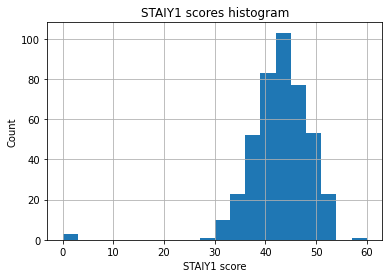

,STAIY1Score
Control,41.7 $\pm$ 8.0 (n=144)
Placebo,42.8 $\pm$ 5.3 (n=143)
ORS,42.8 $\pm$ 4.8 (n=142)
KW p value,0.715
"(Control, Placebo)",1.000
"(Control, ORS)",1.000
"(Placebo, ORS)",1.000


Shapiro-Wilk p-value for STAIY1Score = 2.05E-19
If p < 0.05, then reject null hypothesis that distribution is normally distributed


,VVR_any True,VVR_any False,p-value
STAI_Y1_#1,2.9 $\pm$ 0.7 (n=48),3.1 $\pm$ 0.7 (n=378),0.131
STAI_Y1_#2,2.9 $\pm$ 0.8 (n=48),3.1 $\pm$ 0.7 (n=378),0.084
STAI_Y1_#3,1.5 $\pm$ 0.7 (n=48),1.4 $\pm$ 0.7 (n=378),0.009
STAI_Y1_#4,1.8 $\pm$ 0.7 (n=48),1.6 $\pm$ 0.6 (n=378),0.003
STAI_Y1_#5,2.9 $\pm$ 0.7 (n=48),2.9 $\pm$ 0.8 (n=378),0.249
STAI_Y1_#6,1.5 $\pm$ 0.7 (n=48),1.4 $\pm$ 0.6 (n=378),0.009
STAI_Y1_#7,1.2 $\pm$ 0.5 (n=48),1.2 $\pm$ 0.5 (n=378),0.014
STAI_Y1_#8,2.9 $\pm$ 0.7 (n=48),3.1 $\pm$ 0.7 (n=378),0.309
STAI_Y1_#9,1.4 $\pm$ 0.5 (n=48),1.3 $\pm$ 0.5 (n=378),0.020
STAI_Y1_#10,2.8 $\pm$ 0.7 (n=48),2.9 $\pm$ 0.7 (n=378),0.475


,delayed,immediate_or_both,none,Kruskal Wallis p-value,delayed - immediate_or_both,delayed - none,immediate_or_both - none
STAI_Y1_#1,2.9 $\pm$ 0.8 (n=40),2.9 $\pm$ 0.6 (n=8),3.1 $\pm$ 0.7 (n=378),0.118,0.343,0.321,1.000
STAI_Y1_#2,2.9 $\pm$ 0.8 (n=40),2.9 $\pm$ 0.6 (n=8),3.1 $\pm$ 0.7 (n=378),0.106,0.446,0.240,1.000
STAI_Y1_#3,1.4 $\pm$ 0.6 (n=40),1.9 $\pm$ 1.1 (n=8),1.4 $\pm$ 0.7 (n=378),0.005,0.207,1.000,0.033
STAI_Y1_#4,1.9 $\pm$ 0.7 (n=40),1.5 $\pm$ 0.5 (n=8),1.6 $\pm$ 0.6 (n=378),0.025,1.000,0.092,0.671
STAI_Y1_#5,3.0 $\pm$ 0.7 (n=40),2.5 $\pm$ 0.8 (n=8),2.9 $\pm$ 0.8 (n=378),0.793,1.000,1.000,1.000
STAI_Y1_#6,1.6 $\pm$ 0.8 (n=40),1.4 $\pm$ 0.5 (n=8),1.4 $\pm$ 0.6 (n=378),0.034,1.000,0.521,0.248
STAI_Y1_#7,1.2 $\pm$ 0.4 (n=40),1.5 $\pm$ 0.5 (n=8),1.2 $\pm$ 0.5 (n=378),0.000,0.026,1.000,0.009
STAI_Y1_#8,3.0 $\pm$ 0.7 (n=40),2.8 $\pm$ 0.9 (n=8),3.1 $\pm$ 0.7 (n=378),0.414,0.808,1.000,1.000
STAI_Y1_#9,1.4 $\pm$ 0.5 (n=40),1.4 $\pm$ 0.5 (n=8),1.3 $\pm$ 0.5 (n=378),0.020,0.441,1.000,0.126
STAI_Y1_#10,2.7 $\pm$ 0.7 (n=40),3.0 $\pm$ 0.5 (n=8),2.9 $\pm$ 0.7 (n=378),0.044,0.069,0.874,0.152


In [28]:
display(df[STAIY1_cols].describe().T[['count','mean','std','min','max']])

df.STAIY1Score.hist(bins=20)
plt.title('STAIY1 scores histogram')
plt.xlabel('STAIY1 score')
plt.ylabel('Count');
plt.show()

pairs = list(itertools.combinations(types,2))
res = pd.DataFrame(index=['STAIY1Score'],columns=types+['KW p value']+pairs)
data = [df[df.type==t]['STAIY1Score'] for t in types]
stat,p_omni,z_pair,p_corr,_ = kw_dunn(data)
res.loc['STAIY1Score',:] = ['%.1f $\pm$ %.1f (n=%d)'%(data[i].mean(),data[i].std(),data[i].count()) for i in range(len(data))]+\
                                [p_omni] + list(p_corr)
display(res.T)

#Normality test for the above distribution:
import scipy.stats as stats
(w,p) = stats.shapiro(df['STAIY1Score'])
print("Shapiro-Wilk p-value for STAIY1Score = %.2E"%p)
print("If p < 0.05, then reject null hypothesis that distribution is normally distributed")

res = pd.DataFrame(index=STAIY1_cols,columns=['VVR_any True', 'VVR_any False','p-value'])
for b in STAIY1_cols:
    t,f = df[df.VVR_any==True][b],df[df.VVR_any==False][b]
    stat,p = stats.mannwhitneyu(t,f)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(), t.count()),"%.1f $\pm$ %.1f (n=%d)"%(f.mean(), f.std(),f.count()),p]
display(res)

vvrs = list(np.unique(df.VVR_occurrence))
pairs = [" - ".join(pair) for pair in itertools.combinations(vvrs,2)]
res = pd.DataFrame(index=STAIY1_cols,columns=vvrs+['Kruskal Wallis p-value']+pairs)
for b in STAIY1_cols:
    data = [df.groupby('VVR_occurrence').get_group(v)[b] for v in vvrs]
    stat,p_omni,z_pairs,p_corr,_ = kw_dunn(data)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(),t.count()) for t in data]+[p_omni]+[p_corr[i] for i in range(len(pairs))]
display(res)

,count,mean,std,min,max
STAI_Y2_#1,426.000,2.923,0.607,1.000,4.000
STAI_Y2_#2,426.000,1.655,0.644,1.000,4.000
STAI_Y2_#3,426.000,2.746,0.690,1.000,4.000
STAI_Y2_#4,426.000,2.509,0.931,1.000,4.000
STAI_Y2_#5,426.000,1.460,0.609,1.000,4.000
STAI_Y2_#6,426.000,2.650,0.670,1.000,4.000
STAI_Y2_#7,426.000,2.728,0.710,1.000,4.000
STAI_Y2_#8,426.000,1.587,0.646,1.000,4.000
STAI_Y2_#9,426.000,1.918,0.812,1.000,4.000
STAI_Y2_#10,426.000,3.002,0.627,1.000,4.000


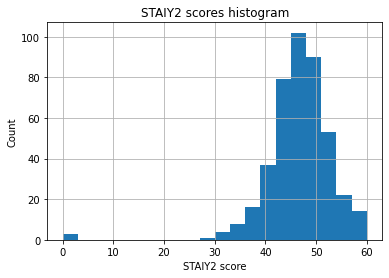

,STAIY2Score
Control,45.8 $\pm$ 8.4 (n=144)
Placebo,45.9 $\pm$ 5.6 (n=143)
ORS,46.6 $\pm$ 5.0 (n=142)
KW p value,0.822
"(Control, Placebo)",1.000
"(Control, ORS)",1.000
"(Placebo, ORS)",1.000


Shapiro-Wilk p-value for STAIY2Score = 1.44E-20
If p < 0.05, then reject null hypothesis that distribution is normally distributed


,VVR_any True,VVR_any False,p-value
STAI_Y2_#1,3.0 $\pm$ 0.5 (n=48),2.9 $\pm$ 0.6 (n=378),0.140
STAI_Y2_#2,1.8 $\pm$ 0.7 (n=48),1.6 $\pm$ 0.6 (n=378),0.014
STAI_Y2_#3,2.6 $\pm$ 0.5 (n=48),2.8 $\pm$ 0.7 (n=378),0.197
STAI_Y2_#4,2.4 $\pm$ 0.9 (n=48),2.5 $\pm$ 0.9 (n=378),0.474
STAI_Y2_#5,1.6 $\pm$ 0.6 (n=48),1.4 $\pm$ 0.6 (n=378),0.012
STAI_Y2_#6,2.6 $\pm$ 0.6 (n=48),2.7 $\pm$ 0.7 (n=378),0.468
STAI_Y2_#7,2.7 $\pm$ 0.7 (n=48),2.7 $\pm$ 0.7 (n=378),0.316
STAI_Y2_#8,1.7 $\pm$ 0.8 (n=48),1.6 $\pm$ 0.6 (n=378),0.092
STAI_Y2_#9,2.1 $\pm$ 0.9 (n=48),1.9 $\pm$ 0.8 (n=378),0.037
STAI_Y2_#10,3.0 $\pm$ 0.6 (n=48),3.0 $\pm$ 0.6 (n=378),0.261


,delayed,immediate_or_both,none,Kruskal Wallis p-value,delayed - immediate_or_both,delayed - none,immediate_or_both - none
STAI_Y2_#1,3.0 $\pm$ 0.5 (n=40),3.0 $\pm$ 0.0 (n=8),2.9 $\pm$ 0.6 (n=378),0.093,0.369,1.000,0.228
STAI_Y2_#2,1.9 $\pm$ 0.7 (n=40),1.5 $\pm$ 0.5 (n=8),1.6 $\pm$ 0.6 (n=378),0.085,1.000,0.285,0.718
STAI_Y2_#3,2.6 $\pm$ 0.5 (n=40),2.6 $\pm$ 0.5 (n=8),2.8 $\pm$ 0.7 (n=378),0.129,0.296,0.468,0.859
STAI_Y2_#4,2.4 $\pm$ 0.9 (n=40),2.6 $\pm$ 1.1 (n=8),2.5 $\pm$ 0.9 (n=378),0.107,0.131,1.000,0.251
STAI_Y2_#5,1.6 $\pm$ 0.7 (n=40),1.4 $\pm$ 0.5 (n=8),1.4 $\pm$ 0.6 (n=378),0.064,1.000,0.384,0.469
STAI_Y2_#6,2.5 $\pm$ 0.6 (n=40),2.8 $\pm$ 0.5 (n=8),2.7 $\pm$ 0.7 (n=378),0.048,0.079,0.887,0.171
STAI_Y2_#7,2.7 $\pm$ 0.7 (n=40),2.6 $\pm$ 0.5 (n=8),2.7 $\pm$ 0.7 (n=378),0.419,0.802,1.000,0.715
STAI_Y2_#8,1.8 $\pm$ 0.8 (n=40),1.4 $\pm$ 0.5 (n=8),1.6 $\pm$ 0.6 (n=378),0.375,1.000,1.000,1.000
STAI_Y2_#9,2.1 $\pm$ 0.9 (n=40),1.8 $\pm$ 0.9 (n=8),1.9 $\pm$ 0.8 (n=378),0.189,1.000,0.553,0.779
STAI_Y2_#10,2.9 $\pm$ 0.6 (n=40),3.4 $\pm$ 0.5 (n=8),3.0 $\pm$ 0.6 (n=378),0.004,0.013,1.000,0.018


In [29]:
display(df[STAIY2_cols].describe().T[['count','mean','std','min','max']])

df.STAIY2Score.hist(bins=20)
plt.title('STAIY2 scores histogram')
plt.xlabel('STAIY2 score')
plt.ylabel('Count');
plt.show()

pairs = list(itertools.combinations(types,2))
res = pd.DataFrame(index=['STAIY2Score'],columns=types+['KW p value']+pairs)
data = [df[df.type==t]['STAIY2Score'] for t in types]
stat,p_omni,z_pair,p_corr,_ = kw_dunn(data)
res.loc['STAIY2Score',:] = ['%.1f $\pm$ %.1f (n=%d)'%(data[i].mean(),data[i].std(),data[i].count()) for i in range(len(data))]+\
                                [p_omni] + list(p_corr)
display(res.T)

#Normality test for the above distribution:
import scipy.stats as stats
(w,p) = stats.shapiro(df['STAIY2Score'])
print("Shapiro-Wilk p-value for STAIY2Score = %.2E"%p)
print("If p < 0.05, then reject null hypothesis that distribution is normally distributed")

res = pd.DataFrame(index=STAIY2_cols,columns=['VVR_any True', 'VVR_any False','p-value'])
for b in STAIY2_cols:
    t,f = df[df.VVR_any==True][b],df[df.VVR_any==False][b]
    stat,p = stats.mannwhitneyu(t,f)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(), t.count()),"%.1f $\pm$ %.1f (n=%d)"%(f.mean(), f.std(),f.count()),p]
display(res)

vvrs = list(np.unique(df.VVR_occurrence))
pairs = [" - ".join(pair) for pair in itertools.combinations(vvrs,2)]
res = pd.DataFrame(index=STAIY2_cols,columns=vvrs+['Kruskal Wallis p-value']+pairs)
for b in STAIY2_cols:
    data = [df.groupby('VVR_occurrence').get_group(v)[b] for v in vvrs]
    stat,p_omni,z_pairs,p_corr,_ = kw_dunn(data)
    res.loc[b,:] = ["%.1f $\pm$ %.1f (n=%d)"%(t.mean(), t.std(),t.count()) for t in data]+[p_omni]+[p_corr[i] for i in range(len(pairs))]
display(res)

almost never     257
sometimes        146
often             21
almost always      2
Name: sSTAI_Y2_#21, dtype: int64

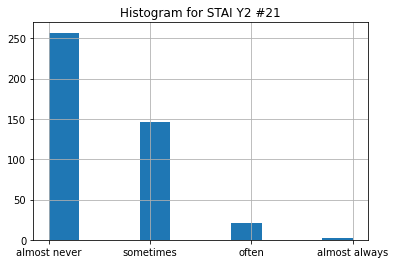

VVR_any (n=429),True,False
STAI_Y2_#21,,
almost never,29,228
"sometimes, often or almost always",22,150


,Chi-squared correlation test
p value,0.749
odds ratio,0.867
CI on OR,"(0.48, 1.57)"


VVR_any (n=429),True,False
STAI_Y2_#21,,
almost never or sometimes,46,357
often or almost always,5,21


,Chi-squared correlation test
p value,0.378
odds ratio,0.541
CI on OR,"(0.19, 1.50)"


VVR_occurrence (n=418),none,delayed
STAI_Y2_#21,,
almost never,228,25
"sometimes, often or almost always",150,15


,Chi-squared correlation test
p value,0.922
odds ratio,0.912
CI on OR,"(0.47, 1.79)"


VVR_occurrence (n=418),none,delayed
STAI_Y2_#21,,
almost never or sometimes,357,38
often or almost always,21,2


,Fisher Exact Test (small sample size)
p value,1.000
odds ratio,0.895
CI on OR,"(0.20, 3.96)"


In [30]:
df['sSTAI_Y2_#21'] = df['STAI_Y2_#21'].replace({1:'almost never',
                                              2:'sometimes',
                                              3:'often',
                                              4:'almost always'})
df['STAI_Y2_#21'].hist()
plt.title('Histogram for STAI Y2 #21');
plt.xticks(np.arange(1,5),['almost never','sometimes','often','almost always']);
display(df['sSTAI_Y2_#21'].value_counts())
plt.show()

pt = pd.crosstab(df['STAI_Y2_#21'].apply(lambda x: "almost never" if x==1 else "sometimes, often or almost always"),df['VVR_any'])
pt = pt.sort_values('VVR_any',axis=1,ascending=False)
pt.columns.name += ' (n=%d)'%pt.values.sum()
display(pt)
display(contingency_analyse(pt))

pt = pd.crosstab(df['STAI_Y2_#21'].apply(lambda x: "almost never or sometimes" if x==1 or x==2 else "often or almost always"),df['VVR_any'])
pt = pt.sort_values('VVR_any',axis=1,ascending=False)
pt.columns.name += ' (n=%d)'%pt.values.sum()
display(pt)
display(contingency_analyse(pt))

pt = pd.crosstab(
    df['STAI_Y2_#21'].apply(lambda x: "almost never" if x==1 else "sometimes, often or almost always"),
    df.VVR_occurrence[(df.VVR_occurrence == 'none')|(df.VVR_occurrence == 'delayed')],
    margins = False
).sort_values('VVR_occurrence',axis=1,ascending=False)
pt.columns.name += ' (n=%d)'%pt.values.sum()
display(pt)
display(contingency_analyse(pt))

pt = pd.crosstab(
    df['STAI_Y2_#21'].apply(lambda x: "almost never or sometimes" if x==1 or x==2 else "often or almost always"),
    df.VVR_occurrence[(df.VVR_occurrence == 'none')|(df.VVR_occurrence == 'delayed')],
    margins = False
).sort_values('VVR_occurrence',axis=1,ascending=False)
pt.columns.name += ' (n=%d)'%pt.values.sum()
display(pt)
display(contingency_analyse(pt))

# Times Analysis

,time #,count,mean,std,min,25%,50%,75%,max
Prehy_sit_Time,1,429.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Prehy_stand_Time,2,429.000,1.242,0.450,0.000,1.000,1.000,1.000,3.000
Posthy_sit_Time,3,429.000,20.000,0.000,20.000,20.000,20.000,20.000,20.000
Posthy_ss_Time,4,429.000,21.520,1.305,20.000,21.000,21.000,22.000,40.000
Posthy_0.5ss_Time,5,426.000,38.969,4.594,31.000,36.000,38.000,41.000,66.000
Posthy_1ss_Time,6,423.000,43.383,5.112,34.000,40.000,43.000,46.000,71.000
Posthy_post5ss_Time,7,424.000,48.858,5.089,38.000,45.000,48.000,52.000,77.000
Posthy_post10ss_Time,8,421.000,53.924,5.089,44.000,50.000,53.000,57.000,82.000
Posthy_post10sit_Time,9,421.000,55.209,5.120,45.000,51.000,54.000,58.000,83.000
Posthy_post10stand_Time,10,421.000,56.444,5.159,46.000,53.000,55.000,59.000,85.000


,count,mean,std,min,25%,50%,75%,max
time_3_6,423.000,23.383,5.112,14.000,20.000,23.000,26.000,51.000
time_3_10,421.000,36.444,5.159,26.000,33.000,35.000,39.000,65.000
time_6_10,416.000,13.046,0.873,11.000,13.000,13.000,13.000,18.000
time_4_10,421.000,34.931,5.205,21.000,31.000,34.000,38.000,64.000
time_3_5,426.000,18.969,4.594,11.000,16.000,18.000,21.000,46.000


C:\Users\alexa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\alexa\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\alexa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\alexa\anaconda3\lib\site-packages\seaborn\distr

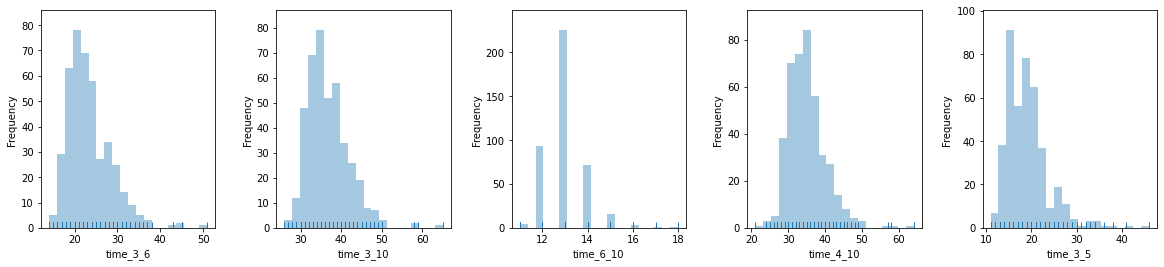

In [9]:
timecols = [e+"Time" for e in eventnames]
res = df[timecols].describe().T
res.insert(0,'time #',np.arange(1,len(res)+1))
display(res)
df['time_3_10'] = (df[timecols[9]] - df[timecols[2]])
df['time_3_6'] = (df[timecols[5]] - df[timecols[2]])
df['time_6_10'] = (df[timecols[9]] - df[timecols[5]])
df['time_4_10'] = (df[timecols[9]] - df[timecols[3]])
df['time_3_5'] = (df[timecols[4]] - df[timecols[2]])
display(df[['time_3_6','time_3_10','time_6_10','time_4_10','time_3_5']].describe().T)
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
sns.distplot(df.time_3_6,kde=False,rug=True,bins=20);
plt.ylabel('Frequency');
plt.subplot(1,5,2)
sns.distplot(df.time_3_10,kde=False,rug=True,bins=20);
plt.ylabel('Frequency');
plt.subplot(1,5,3)
sns.distplot(df.time_6_10,kde=False,rug=True,bins=20);
plt.ylabel('Frequency');
plt.subplot(1,5,4)
sns.distplot(df.time_4_10,kde=False,rug=True,bins=20);
plt.ylabel('Frequency');
plt.subplot(1,5,5)
sns.distplot(df.time_3_5,kde=False,rug=True,bins=20);
plt.ylabel('Frequency');
plt.subplots_adjust(wspace=0.35)

In [10]:
res = df.groupby(['type','VVR_any'])[['time_3_6','time_3_10', 'time_6_10','time_4_10','time_3_5']].describe()
res.drop(['min','25%','75%','max'],axis=1,level=1,inplace=True)
display(res)
times = ['time_3_6','time_3_10','time_6_10','time_4_10','time_3_5']
types = ['Control','Placebo','ORS']
res = pd.DataFrame(index=types,columns=times)
for time in times:
    for t in types:
        val, pval = stats.mannwhitneyu(
            *[df[df.type==t].groupby('VVR_any')[time].get_group(g) for g in np.unique(df.VVR_any)]
        )
        res.loc[t,time] = pval
res.columns.name = 'Mann Whitney U p-values for VVR_any'
display(res)

time_3_6                     time_3_10                      \
                   count   mean   std    50%     count   mean   std    50%   
type    VVR_any                                                              
Control False    124.000 23.516 4.628 23.000   125.000 36.616 4.721 36.000   
        True      19.000 24.105 6.732 22.000    14.000 35.500 4.433 34.000   
ORS     False    126.000 23.214 4.423 23.000   127.000 36.228 4.478 35.000   
        True      15.000 24.000 3.910 22.000    13.000 37.385 4.032 36.000   
Placebo False    123.000 23.301 5.560 22.000   126.000 36.563 5.822 35.000   
        True      16.000 22.875 8.632 22.000    16.000 35.938 8.797 34.500   

                time_6_10                     time_4_10                      \
                    count   mean   std    50%     count   mean   std    50%   
type    VVR_any                                                               
Control False     124.000 13.065 1.026 13.000   125.000 35.088 4.668 34.000   
        True       14.000 12.643 0.745 12.500    14.000 34.071 4.615 32.500   
ORS     False     126.000 13.008 0.853 13.000   127.000 34.772 4.529 34.000   
        True       13.000 13.000 0.707 13.000    13.000 35.923 4.291 35.000   
Placebo False     123.000 13.114 0.760 13.000   126.000 34.960 5.931 34.000   
        True       16.000 13.062 0.772 13.000    16.000 34.688 8.822 33.500   

                time_3_5                      
                   count   mean   std    50%  
type    VVR_any                               
Control False    124.000 19.032 3.870 18.500  
        True      19.000 19.789 5.855 18.000  
ORS     False    127.000 18.709 3.910 18.000  
        True      14.000 19.000 3.595 18.500  
Placebo False    125.000 19.072 5.243 18.000  
        True      17.000 18.765 7.846 17.000

Mann Whitney U p-values for VVR_any,time_3_6,time_3_10,time_6_10,time_4_10,time_3_5
Control,0.444,0.141,0.281,0.134,0.459
Placebo,0.287,0.307,0.442,0.377,0.233
ORS,0.239,0.034,0.175,0.042,0.241


In [11]:
res = df.groupby(['type','VVR_occurrence'])[['time_3_6','time_3_10', 'time_6_10','time_4_10','time_3_5']].describe()
res.drop(['min','25%','75%','max'],axis=1,level=1,inplace=True)
display(res)
import itertools
times = ['time_3_6','time_3_10','time_6_10','time_4_10','time_3_5']
types = ['Control','Placebo','ORS']
grps = np.unique(df.VVR_occurrence)
pairs = [" - ".join(p) for p in itertools.combinations(grps,2)]
res = pd.DataFrame(index=pd.MultiIndex.from_product([times,types]),columns=['Kruskal-Wallis P']+pairs)
for time in times:
    for t in types:
        grps, cnts = np.unique(df[df.type==t].VVR_occurrence,return_counts=True)
        grps = grps[cnts>=5]
        if len(grps) > 1:
            pairs = [" - ".join(p) for p in itertools.combinations(grps,2)]
            H,p_o,Z,p_corr,_ = kw_dunn(
                [df[df.type==t].groupby('VVR_occurrence')[time].get_group(g) for g in grps]
            )
            res.loc[(time,t),'Kruskal-Wallis P'] = p_o
            for i in range(len(p_corr)):
                res.loc[(time,t),pairs[i]] = p_corr[i]
display(res)

time_3_6                     time_3_10               \
                             count   mean   std    50%     count   mean   std   
type    VVR_occurrence                                                          
Control delayed             11.000 23.182 3.970 22.000    11.000 35.909 4.527   
        immediate_or_both    8.000 25.375 9.531 23.500     3.000 34.000 4.583   
        none               124.000 23.516 4.628 23.000   125.000 36.616 4.721   
ORS     delayed             13.000 24.385 4.032 22.000    13.000 37.385 4.032   
        immediate_or_both    2.000 21.500 2.121 21.500     0.000    nan   nan   
        none               126.000 23.214 4.423 23.000   127.000 36.228 4.478   
Placebo delayed             16.000 22.875 8.632 22.000    16.000 35.938 8.797   
        immediate_or_both    0.000    nan   nan    nan     0.000    nan   nan   
        none               123.000 23.301 5.560 22.000   126.000 36.563 5.822   

                                 time_6_10                     time_4_10  \
                             50%     count   mean   std    50%     count   
type    VVR_occurrence                                                     
Control delayed           34.000    11.000 12.727 0.786 13.000    11.000   
        immediate_or_both 33.000     3.000 12.333 0.577 12.000     3.000   
        none              36.000   124.000 13.065 1.026 13.000   125.000   
ORS     delayed           36.000    13.000 13.000 0.707 13.000    13.000   
        immediate_or_both    nan     0.000    nan   nan    nan     0.000   
        none              35.000   126.000 13.008 0.853 13.000   127.000   
Placebo delayed           34.500    16.000 13.062 0.772 13.000    16.000   
        immediate_or_both    nan     0.000    nan   nan    nan     0.000   
        none              35.000   123.000 13.114 0.760 13.000   126.000   

                                              time_3_5                      
                            mean   std    50%    count   mean   std    50%  
type    VVR_occurrence                                                      
Control delayed           34.364 4.802 33.000   11.000 18.909 2.879 18.000  
        immediate_or_both 33.000 4.583 32.000    8.000 21.000 8.569 19.500  
        none              35.088 4.668 34.000  124.000 19.032 3.870 18.500  
ORS     delayed           35.923 4.291 35.000   12.000 19.333 3.774 19.000  
        immediate_or_both    nan   nan    nan    2.000 17.000 1.414 17.000  
        none              34.772 4.529 34.000  127.000 18.709 3.910 18.000  
Placebo delayed           34.688 8.822 33.500   16.000 18.688 8.097 17.000  
        immediate_or_both    nan   nan    nan    1.000 20.000   nan 20.000  
        none              34.960 5.931 34.000  125.000 19.072 5.243 18.000

Kruskal-Wallis P delayed - immediate_or_both delayed - none  \
time_3_6  Control            0.986                       1.000          1.000   
          Placebo            0.321                         NaN          0.322   
          ORS                0.335                         NaN          0.336   
time_3_10 Control            0.046                       0.077          1.000   
          Placebo            0.352                         NaN          0.353   
          ORS                0.287                         NaN          0.288   
time_6_10 Control            0.041                       0.070          0.947   
          Placebo            0.773                         NaN          0.791   
          ORS                0.984                         NaN          0.986   
time_4_10 Control            0.034                       0.056          1.000   
          Placebo            0.463                         NaN          0.464   
          ORS                0.338                         NaN          0.340   
time_3_5  Control            0.993                       1.000          1.000   
          Placebo            0.363                         NaN          0.365   
          ORS                0.319                         NaN          0.322   

                  immediate_or_both - none  
time_3_6  Control                    1.000  
          Placebo                      NaN  
          ORS                          NaN  
time_3_10 Control                    0.053  
          Placebo                      NaN  
          ORS                          NaN  
time_6_10 Control                    0.129  
          Placebo                      NaN  
          ORS                          NaN  
time_4_10 Control                    0.039  
          Placebo                      NaN  
          ORS                          NaN  
time_3_5  Control                    1.000  
          Placebo                      NaN  
          ORS                          NaN

In [12]:
for p in HDparam:
    df[p + "_3_6"] = (df[eventnames[5]+p] - df[eventnames[2]+p]) / df[eventnames[2]+p]
    df[p + "_3_10"] = (df[eventnames[9]+p] - df[eventnames[2]+p]) / df[eventnames[2]+p]
    df[p + "_6_10"] = (df[eventnames[9]+p] - df[eventnames[5]+p]) / df[eventnames[5]+p]
    df[p + "_4_10"] = (df[eventnames[9]+p] - df[eventnames[3]+p]) / df[eventnames[3]+p]
    df[p + "_3_5"] = (df[eventnames[4]+p] - df[eventnames[2]+p]) / df[eventnames[2]+p]

In [13]:
tstring = "_4_10"
df2 = df.dropna(subset=[p+tstring for p in HDparam])
res = pd.DataFrame(index = ["change in "+p for p in HDparam],
                  columns = pd.MultiIndex.from_product([types+['All'],['P-value','mean % diff','stdev % diff']],names=['Event ' + tstring,'Value']))
for p in HDparam:
    for t in types+['All']:
        row = {}
        if t == 'All':
            r, pval =  stats.pearsonr(df2['time'+tstring],df2[p+tstring])
        else:
            r, pval =  stats.pearsonr(df2[df2.type==t]['time'+tstring],df2[df2.type==t][p+tstring])
        #res.loc["change in "+p,(t,'Pearson R')] = r
        res.loc["change in "+p,(t,'P-value')] =pval
        res.loc["change in "+p,(t,'mean % diff')] =df2[p+tstring].mean()
        res.loc["change in "+p,(t,'stdev % diff')] =df2[p+tstring].std()
display(res)

df['percentile'+tstring] = pd.qcut(df['time'+tstring],2,labels=['lower 50%','upper 50%'])
pt = pd.pivot_table(df,index='type',columns=['percentile'+tstring,'VVR_any'],values='case#',aggfunc='count')
pt.columns.names = ['time'+tstring,'VVR_any']
pt = pt.reindex(sorted(pt.columns,reverse=True),axis=1)
display(pt)

res = pd.DataFrame()
for t in ['upper 50%','lower 50%']:
    for (a,b) in itertools.combinations(types,2):
        ser = contingency_analyse(pt.loc[[a,b],t])
        ser.columns = [ser.columns[0] + ' for '+t+' time%s'%tstring]
        res["( %s, %s ) "%(a,b)+t] = ser.iloc[:,0]
res.columns.name = "Chi-squared correlation test"
display(res.T)

pt = pd.pivot_table(df,index='type',
                    columns=['percentile'+tstring,'VVR_occurrence'],
                    values='case#',aggfunc='count',fill_value=0)
display(pt.sort_index(axis=1,ascending=False))

res = pd.DataFrame()
for t in ['upper 50%','lower 50%']:
    for (a,b) in itertools.combinations(types,2):
        for (i,j) in itertools.combinations(np.unique(df.VVR_occurrence),2):
            if pt.loc[[a,b],(t,[i,j])].values.min() >= 5:
                ser = contingency_analyse(pt.loc[[a,b],(t,[i,j])])
                ser.columns = [ser.columns[0] + ' for '+t+' time%s'%tstring]
                res["( %s, %s ) "%(a,b)+" ( %s, %s ) "%(i,j) +t] = ser.iloc[:,0]
res.columns.name = "Chi-squared correlation test"
display(res.T)

res = pd.DataFrame(columns=['Delayed','Immi or both','Total'], index = ['upper 50%','lower 50%'])
for percentile in ['upper 50%','lower 50%']:
    res.loc[percentile,'Delayed'] = stats.chi2_contingency( pt.loc[:,percentile][['delayed','none']] )[1]
    res.loc[percentile,'Immi or both'] = stats.chi2_contingency( pt.loc[:,percentile][['immediate_or_both','none']])[1]
    pt.loc[:,(percentile,'total')] = pt.loc[:,percentile].loc[:,:'immediate_or_both'].sum(axis=1)
    res.loc[percentile,'Total'] = stats.chi2_contingency( pt.loc[:,percentile][['total','none']])[1]
res.columns.name = 'Chi2 p-values across all types'
display(res)

Event _4_10   Control                          Placebo              \
Value         P-value mean % diff stdev % diff P-value mean % diff   
change in CO    0.342      -0.265        0.190   0.035      -0.265   
change in SV    0.243      -0.423        0.144   0.086      -0.423   
change in HR    0.348       0.290        0.226   0.349       0.290   
change in SVR   0.549       0.577        0.427   0.116       0.577   
change in SBP   0.918       0.095        0.121   0.041       0.095   
change in DBP   0.216       0.077        0.132   0.137       0.077   
change in MAP   0.507       0.083        0.106   0.031       0.083   
change in PP    0.813       0.165        0.352   0.965       0.165   

Event _4_10                    ORS                              All  \
Value         stdev % diff P-value mean % diff stdev % diff P-value   
change in CO         0.190   0.738      -0.265        0.190   0.085   
change in SV         0.144   0.244      -0.423        0.144   0.218   
change in HR         0.226   0.303       0.290        0.226   0.528   
change in SVR        0.427   0.746       0.577        0.427   0.194   
change in SBP        0.121   0.878       0.095        0.121   0.116   
change in DBP        0.132   0.852       0.077        0.132   0.529   
change in MAP        0.106   0.849       0.083        0.106   0.174   
change in PP         0.352   0.897       0.165        0.352   0.829   

Event _4_10                             
Value         mean % diff stdev % diff  
change in CO       -0.265        0.190  
change in SV       -0.423        0.144  
change in HR        0.290        0.226  
change in SVR       0.577        0.427  
change in SBP       0.095        0.121  
change in DBP       0.077        0.132  
change in MAP       0.083        0.106  
change in PP        0.165        0.352

time_4_10 upper 50%       lower 50%      
VVR_any       True  False     True  False
type                                     
Control           6    62         8    63
ORS               8    59         5    68
Placebo           6    55        10    71

,p value,odds ratio,CI on OR
Chi-squared correlation test,,,
"( Control, Placebo ) upper 50%",0.916,0.887,"(0.27, 2.91)"
"( Control, ORS ) upper 50%",0.755,0.714,"(0.23, 2.18)"
"( Placebo, ORS ) upper 50%",0.922,0.805,"(0.26, 2.47)"
"( Control, Placebo ) lower 50%",0.963,0.902,"(0.34, 2.43)"
"( Control, ORS ) lower 50%",0.526,1.727,"(0.54, 5.56)"
"( Placebo, ORS ) lower 50%",0.381,1.915,"(0.62, 5.89)"


percentile_4_10 upper 50%                           lower 50%  \
VVR_occurrence       none immediate_or_both delayed      none   
type                                                            
Control                62                 1       5        63   
ORS                    59                 0       8        68   
Placebo                55                 0       6        71   

percentile_4_10                            
VVR_occurrence  immediate_or_both delayed  
type                                       
Control                         2       6  
ORS                             0       5  
Placebo                         0      10

,p value,odds ratio,CI on OR
Chi-squared correlation test,,,
"( Control, Placebo ) ( delayed, none ) upper 50%",0.871,0.739,"(0.21, 2.56)"
"( Control, ORS ) ( delayed, none ) upper 50%",0.559,0.595,"(0.18, 1.92)"
"( Placebo, ORS ) ( delayed, none ) upper 50%",0.922,0.805,"(0.26, 2.47)"
"( Control, Placebo ) ( delayed, none ) lower 50%",0.648,0.676,"(0.23, 1.97)"
"( Control, ORS ) ( delayed, none ) lower 50%",0.922,1.295,"(0.38, 4.45)"
"( Placebo, ORS ) ( delayed, none ) lower 50%",0.381,1.915,"(0.62, 5.89)"


Chi2 p-values across all types,Delayed,Immi or both,Total
upper 50%,0.682,0.403,0.831
lower 50%,0.491,0.115,0.500


In [48]:
pt = pd.pivot_table(df,index='type',columns=['percentile_3_10','VVR_any'],values='case#',aggfunc='count')
pt = pt.reindex(sorted(pt.columns,reverse=True),axis=1)
up = stats.chi2_contingency(pt.loc[:,'upper 50%'])[1]
lo = stats.chi2_contingency(pt.loc[:,'lower 50%'])[1]
pt.loc['p_value',('upper 50%',True)] = up
pt.loc['p_value',('upper 50%',False)] = '-'
pt.loc['p_value',('lower 50%',True)] = lo
pt.loc['p_value',('lower 50%',False)] = '-'
display(pt)

pt = pd.pivot_table(df,index='type',columns=['percentile_4_10','VVR_any'],values='case#',aggfunc='count')
pt = pt.reindex(sorted(pt.columns,reverse=True),axis=1)
up = stats.chi2_contingency(pt.loc[:,'upper 50%'])[1]
lo = stats.chi2_contingency(pt.loc[:,'lower 50%'])[1]
pt.loc['p_value',('upper 50%',True)] = up
pt.loc['p_value',('upper 50%',False)] = '-'
pt.loc['p_value',('lower 50%',True)] = lo
pt.loc['p_value',('lower 50%',False)] = '-'
display(pt)

percentile_3_10 upper 50%        lower 50%       
VVR_any             True   False     True   False
type                                             
Control             6.000 67.000     8.000 58.000
ORS                 8.000 63.000     5.000 64.000
Placebo             6.000 60.000    10.000 66.000
p_value             0.815      -     0.485      -

percentile_4_10 upper 50%        lower 50%       
VVR_any             True   False     True   False
type                                             
Control             6.000 62.000     8.000 63.000
ORS                 8.000 59.000     5.000 68.000
Placebo             6.000 55.000    10.000 71.000
p_value             0.831      -     0.500      -

## Donation time, wait time

In [54]:
df['dt_post_drink'] = df.Posthy_ss_Time - df.Posthy_sit_Time
df['dt_donation'] = (df.donation_end_hhmm - df.donation_start_hhmm).dt.seconds / 60
df['dt_wait'] = df.Posthy_1ss_Time - df.Posthy_ss_Time - df.dt_donation
df['dt_post_donation'] = df.Posthy_post10stand_Time - df.Posthy_1ss_Time

In [80]:
dt_params = list(map(lambda x: x+'_3_10',['CO', 'SV', 'HR', 'SBP', 'DBP', 'MAP', 'SVR']))
res = pd.DataFrame(index=pd.MultiIndex.from_product([dt_params,types+['All']]),
                   columns=['t < median','t >= median', 'MWU p value'])
med = df.dt_wait.median()
for p in dt_params:
    for t in types+['All']:
        if t == 'All':
            lo = df[df.dt_wait < med][p]
            up = df[df.dt_wait >= med][p]
        else:
            lo = df[(df.type==t)&(df.dt_wait < med)][p]
            up = df[(df.type==t)&(df.dt_wait >= med)][p]
        res.loc[(p,t),'t < median'] = "%.3f $\pm$ %.3f (N = %d)"%(lo.mean(),lo.std(),lo.count())
        res.loc[(p,t),'t >= median'] = "%.3f $\pm$ %.3f (N = %d)"%(up.mean(),up.std(),up.count())
        res.loc[(p,t),'MWU p value'] = stats.mannwhitneyu(lo,up,alternative='two-sided')[1]
res.columns.name = 'mean $\pm$ std, median (dt_wait) = %.1f mins'%med 
display(res)
dt_params = list(map(lambda x: x+'_4_10',['CO', 'SV', 'HR', 'SBP', 'DBP', 'MAP', 'SVR']))
res = pd.DataFrame(index=pd.MultiIndex.from_product([dt_params,types+['All']]),
                   columns=['t < median','t >= median', 'MWU p value'])
med = df.dt_wait.median()
for p in dt_params:
    for t in types+['All']:
        if t == 'All':
            lo = df[df.dt_wait < med][p]
            up = df[df.dt_wait >= med][p]
        else:
            lo = df[(df.type==t)&(df.dt_wait < med)][p]
            up = df[(df.type==t)&(df.dt_wait >= med)][p]
        res.loc[(p,t),'t < median'] = "%.3f $\pm$ %.3f (N = %d)"%(lo.mean(),lo.std(),lo.count())
        res.loc[(p,t),'t >= median'] = "%.3f $\pm$ %.3f (N = %d)"%(up.mean(),up.std(),up.count())
        res.loc[(p,t),'MWU p value'] = stats.mannwhitneyu(lo,up,alternative='two-sided')[1]
res.columns.name = 'mean $\pm$ std, median (dt_wait) = %.1f mins'%med 
res

mean $\pm$ std, median (dt_wait) = 11.8 mins                    t < median  \
CO_3_10  Control                               -0.142 $\pm$ 0.236 (N = 64)   
         Placebo                               -0.141 $\pm$ 0.219 (N = 67)   
         ORS                                   -0.114 $\pm$ 0.245 (N = 74)   
         All                                  -0.132 $\pm$ 0.233 (N = 205)   
SV_3_10  Control                               -0.351 $\pm$ 0.166 (N = 64)   
         Placebo                               -0.331 $\pm$ 0.166 (N = 67)   
         ORS                                   -0.349 $\pm$ 0.163 (N = 74)   
         All                                  -0.344 $\pm$ 0.164 (N = 205)   
HR_3_10  Control                                0.334 $\pm$ 0.223 (N = 64)   
         Placebo                                0.300 $\pm$ 0.208 (N = 67)   
         ORS                                    0.377 $\pm$ 0.255 (N = 74)   
         All                                   0.338 $\pm$ 0.232 (N = 205)   
SBP_3_10 Control                                0.050 $\pm$ 0.141 (N = 64)   
         Placebo                                0.049 $\pm$ 0.110 (N = 67)   
         ORS                                    0.054 $\pm$ 0.098 (N = 74)   
         All                                   0.051 $\pm$ 0.116 (N = 205)   
DBP_3_10 Control                                0.007 $\pm$ 0.137 (N = 64)   
         Placebo                                0.033 $\pm$ 0.103 (N = 67)   
         ORS                                    0.028 $\pm$ 0.093 (N = 74)   
         All                                   0.023 $\pm$ 0.111 (N = 205)   
MAP_3_10 Control                                0.025 $\pm$ 0.126 (N = 64)   
         Placebo                                0.039 $\pm$ 0.089 (N = 67)   
         ORS                                    0.038 $\pm$ 0.077 (N = 74)   
         All                                   0.034 $\pm$ 0.098 (N = 205)   
SVR_3_10 Control                                0.286 $\pm$ 0.386 (N = 64)   
         Placebo                                0.293 $\pm$ 0.367 (N = 67)   
         ORS                                    0.258 $\pm$ 0.321 (N = 74)   
         All                                   0.278 $\pm$ 0.356 (N = 205)   

mean $\pm$ std, median (dt_wait) = 11.8 mins                   t >= median  \
CO_3_10  Control                               -0.186 $\pm$ 0.194 (N = 74)   
         Placebo                               -0.185 $\pm$ 0.179 (N = 71)   
         ORS                                   -0.119 $\pm$ 0.187 (N = 65)   
         All                                  -0.165 $\pm$ 0.188 (N = 210)   
SV_3_10  Control                               -0.403 $\pm$ 0.154 (N = 74)   
         Placebo                               -0.370 $\pm$ 0.136 (N = 71)   
         ORS                                   -0.342 $\pm$ 0.140 (N = 65)   
         All                                  -0.373 $\pm$ 0.145 (N = 210)   
HR_3_10  Control                                0.390 $\pm$ 0.234 (N = 74)   
         Placebo                                0.300 $\pm$ 0.192 (N = 71)   
         ORS                                    0.358 $\pm$ 0.226 (N = 65)   
         All                                   0.350 $\pm$ 0.220 (N = 210)   
SBP_3_10 Control                                0.047 $\pm$ 0.103 (N = 74)   
         Placebo                                0.027 $\pm$ 0.099 (N = 71)   
         ORS                                    0.053 $\pm$ 0.118 (N = 65)   
         All                                   0.042 $\pm$ 0.107 (N = 210)   
DBP_3_10 Control                                0.012 $\pm$ 0.094 (N = 74)   
         Placebo                                0.036 $\pm$ 0.127 (N = 71)   
         ORS                                    0.020 $\pm$ 0.104 (N = 65)   
         All                                   0.023 $\pm$ 0.109 (N = 210)   
MAP_3_10 Control                                0.026 $\pm$ 0.071 (N = 74)   
         Placebo     

mean $\pm$ std, median (dt_wait) = 11.8 mins                    t < median  \
CO_4_10  Control                               -0.257 $\pm$ 0.215 (N = 64)   
         Placebo                               -0.263 $\pm$ 0.163 (N = 67)   
         ORS                                   -0.245 $\pm$ 0.209 (N = 74)   
         All                                  -0.254 $\pm$ 0.196 (N = 205)   
SV_4_10  Control                               -0.411 $\pm$ 0.155 (N = 64)   
         Placebo                               -0.407 $\pm$ 0.141 (N = 67)   
         ORS                                   -0.415 $\pm$ 0.146 (N = 74)   
         All                                  -0.411 $\pm$ 0.147 (N = 205)   
HR_4_10  Control                                0.273 $\pm$ 0.208 (N = 64)   
         Placebo                                0.263 $\pm$ 0.212 (N = 67)   
         ORS                                    0.304 $\pm$ 0.254 (N = 74)   
         All                                   0.281 $\pm$ 0.226 (N = 205)   
SBP_4_10 Control                                0.091 $\pm$ 0.141 (N = 64)   
         Placebo                                0.110 $\pm$ 0.118 (N = 67)   
         ORS                                    0.109 $\pm$ 0.107 (N = 74)   
         All                                   0.104 $\pm$ 0.122 (N = 205)   
DBP_4_10 Control                                0.045 $\pm$ 0.137 (N = 64)   
         Placebo                                0.097 $\pm$ 0.115 (N = 67)   
         ORS                                    0.085 $\pm$ 0.101 (N = 74)   
         All                                   0.076 $\pm$ 0.119 (N = 205)   
MAP_4_10 Control                                0.064 $\pm$ 0.125 (N = 64)   
         Placebo                                0.101 $\pm$ 0.100 (N = 67)   
         ORS                                    0.095 $\pm$ 0.088 (N = 74)   
         All                                   0.087 $\pm$ 0.105 (N = 205)   
SVR_4_10 Control                                0.541 $\pm$ 0.450 (N = 64)   
         Placebo                                0.573 $\pm$ 0.408 (N = 67)   
         ORS                                    0.563 $\pm$ 0.420 (N = 74)   
         All                                   0.559 $\pm$ 0.424 (N = 205)   

mean $\pm$ std, median (dt_wait) = 11.8 mins                   t >= median  \
CO_4_10  Control                               -0.301 $\pm$ 0.168 (N = 74)   
         Placebo                               -0.307 $\pm$ 0.183 (N = 71)   
         ORS                                   -0.226 $\pm$ 0.184 (N = 65)   
         All                                  -0.280 $\pm$ 0.181 (N = 210)   
SV_4_10  Control                               -0.471 $\pm$ 0.131 (N = 74)   
         Placebo                               -0.443 $\pm$ 0.134 (N = 71)   
         ORS                                   -0.399 $\pm$ 0.140 (N = 65)   
         All                                  -0.439 $\pm$ 0.137 (N = 210)   
HR_4_10  Control                                0.345 $\pm$ 0.245 (N = 74)   
         Placebo                                0.249 $\pm$ 0.191 (N = 71)   
         ORS                                    0.306 $\pm$ 0.232 (N = 65)   
         All                                   0.301 $\pm$ 0.226 (N = 210)   
SBP_4_10 Control                                0.087 $\pm$ 0.115 (N = 74)   
         Placebo                                0.073 $\pm$ 0.125 (N = 71)   
         ORS                                    0.103 $\pm$ 0.120 (N = 65)   
         All                                   0.087 $\pm$ 0.120 (N = 210)   
DBP_4_10 Control                                0.079 $\pm$ 0.126 (N = 74)   
         Placebo                                0.082 $\pm$ 0.183 (N = 71)   
         ORS                                    0.069 $\pm$ 0.112 (N = 65)   
         All                                   0.077 $\pm$ 0.144 (N = 210)   
MAP_4_10 Control                                0.080 $\pm$ 0.093 (N = 74)   
         Placebo     

In [81]:
dt_params = list(map(lambda x: x+'_3_10',['CO', 'SV', 'HR', 'SBP', 'DBP', 'MAP', 'SVR']))
res = pd.DataFrame(index=pd.MultiIndex.from_product([dt_params,types+['All']]),
                   columns=['t < median','t >= median', 'MWU p value'])
med = df.dt_donation.median()
for p in dt_params:
    for t in types+['All']:
        if t == 'All':
            lo = df[df.dt_donation < med][p]
            up = df[df.dt_donation >= med][p]
        else:
            lo = df[(df.type==t)&(df.dt_donation < med)][p]
            up = df[(df.type==t)&(df.dt_donation >= med)][p]
        res.loc[(p,t),'t < median'] = "%.3f $\pm$ %.3f (N = %d)"%(lo.mean(),lo.std(),lo.count())
        res.loc[(p,t),'t >= median'] = "%.3f $\pm$ %.3f (N = %d)"%(up.mean(),up.std(),up.count())
        res.loc[(p,t),'MWU p value'] = stats.mannwhitneyu(lo,up,alternative='two-sided')[1]
res.columns.name = 'mean $\pm$ std, median (dt_donation) = %.1f mins'%med 
display(res)
dt_params = list(map(lambda x: x+'_4_10',['CO', 'SV', 'HR', 'SBP', 'DBP', 'MAP', 'SVR']))
res = pd.DataFrame(index=pd.MultiIndex.from_product([dt_params,types+['All']]),
                   columns=['t < median','t >= median', 'MWU p value'])
med = df.dt_donation.median()
for p in dt_params:
    for t in types+['All']:
        if t == 'All':
            lo = df[df.dt_donation < med][p]
            up = df[df.dt_donation >= med][p]
        else:
            lo = df[(df.type==t)&(df.dt_donation < med)][p]
            up = df[(df.type==t)&(df.dt_donation >= med)][p]
        res.loc[(p,t),'t < median'] = "%.3f $\pm$ %.3f (N = %d)"%(lo.mean(),lo.std(),lo.count())
        res.loc[(p,t),'t >= median'] = "%.3f $\pm$ %.3f (N = %d)"%(up.mean(),up.std(),up.count())
        res.loc[(p,t),'MWU p value'] = stats.mannwhitneyu(lo,up,alternative='two-sided')[1]
res.columns.name = 'mean $\pm$ std, median (dt_donation) = %.1f mins'%med 
res

mean $\pm$ std, median (dt_donation) = 8.9 mins                    t < median  \
CO_3_10  Control                                  -0.162 $\pm$ 0.235 (N = 69)   
         Placebo                                  -0.134 $\pm$ 0.183 (N = 76)   
         ORS                                      -0.126 $\pm$ 0.192 (N = 64)   
         All                                     -0.141 $\pm$ 0.204 (N = 209)   
SV_3_10  Control                                  -0.372 $\pm$ 0.160 (N = 69)   
         Placebo                                  -0.335 $\pm$ 0.151 (N = 76)   
         ORS                                      -0.355 $\pm$ 0.137 (N = 64)   
         All                                     -0.353 $\pm$ 0.150 (N = 209)   
HR_3_10  Control                                   0.341 $\pm$ 0.210 (N = 69)   
         Placebo                                   0.317 $\pm$ 0.205 (N = 76)   
         ORS                                       0.374 $\pm$ 0.240 (N = 64)   
         All                                      0.343 $\pm$ 0.218 (N = 209)   
SBP_3_10 Control                                   0.053 $\pm$ 0.130 (N = 69)   
         Placebo                                   0.044 $\pm$ 0.106 (N = 76)   
         ORS                                       0.042 $\pm$ 0.114 (N = 64)   
         All                                      0.047 $\pm$ 0.116 (N = 209)   
DBP_3_10 Control                                   0.031 $\pm$ 0.121 (N = 69)   
         Placebo                                   0.030 $\pm$ 0.102 (N = 76)   
         ORS                                       0.018 $\pm$ 0.095 (N = 64)   
         All                                      0.027 $\pm$ 0.106 (N = 209)   
MAP_3_10 Control                                   0.040 $\pm$ 0.112 (N = 69)   
         Placebo                                   0.035 $\pm$ 0.088 (N = 76)   
         ORS                                       0.028 $\pm$ 0.087 (N = 64)   
         All                                      0.034 $\pm$ 0.096 (N = 209)   
SVR_3_10 Control                                   0.341 $\pm$ 0.389 (N = 69)   
         Placebo                                   0.263 $\pm$ 0.299 (N = 76)   
         ORS                                       0.233 $\pm$ 0.277 (N = 64)   
         All                                      0.279 $\pm$ 0.327 (N = 209)   

mean $\pm$ std, median (dt_donation) = 8.9 mins                   t >= median  \
CO_3_10  Control                                  -0.169 $\pm$ 0.192 (N = 70)   
         Placebo                                  -0.197 $\pm$ 0.210 (N = 65)   
         ORS                                      -0.106 $\pm$ 0.240 (N = 76)   
         All                                     -0.155 $\pm$ 0.218 (N = 211)   
SV_3_10  Control                                  -0.382 $\pm$ 0.165 (N = 70)   
         Placebo                                  -0.369 $\pm$ 0.150 (N = 65)   
         ORS                                      -0.337 $\pm$ 0.164 (N = 76)   
         All                                     -0.362 $\pm$ 0.160 (N = 211)   
HR_3_10  Control                                   0.380 $\pm$ 0.250 (N = 70)   
         Placebo                                   0.280 $\pm$ 0.187 (N = 65)   
         ORS                                       0.364 $\pm$ 0.243 (N = 76)   
         All                                      0.344 $\pm$ 0.233 (N = 211)   
SBP_3_10 Control                                   0.046 $\pm$ 0.115 (N = 70)   
         Placebo                                   0.031 $\pm$ 0.102 (N = 65)   
         ORS                                       0.063 $\pm$ 0.101 (N = 76)   
         All                                      0.047 $\pm$ 0.107 (N = 211)   
DBP_3_10 Control                                  -0.008 $\pm$ 0.109 (N = 70)   
         Placebo                                   0.038 $\pm$ 0.127 (N = 65)   
         ORS                                       0.030 $\pm$ 0.101 (N = 76)   
         All                  

mean $\pm$ std, median (dt_donation) = 8.9 mins                    t < median  \
CO_4_10  Control                                  -0.282 $\pm$ 0.215 (N = 69)   
         Placebo                                  -0.253 $\pm$ 0.167 (N = 76)   
         ORS                                      -0.233 $\pm$ 0.204 (N = 64)   
         All                                     -0.257 $\pm$ 0.195 (N = 209)   
SV_4_10  Control                                  -0.440 $\pm$ 0.150 (N = 69)   
         Placebo                                  -0.407 $\pm$ 0.135 (N = 76)   
         ORS                                      -0.413 $\pm$ 0.139 (N = 64)   
         All                                     -0.420 $\pm$ 0.141 (N = 209)   
HR_4_10  Control                                   0.288 $\pm$ 0.202 (N = 69)   
         Placebo                                   0.272 $\pm$ 0.193 (N = 76)   
         ORS                                       0.317 $\pm$ 0.224 (N = 64)   
         All                                      0.291 $\pm$ 0.206 (N = 209)   
SBP_4_10 Control                                   0.095 $\pm$ 0.134 (N = 69)   
         Placebo                                   0.099 $\pm$ 0.117 (N = 76)   
         ORS                                       0.109 $\pm$ 0.130 (N = 64)   
         All                                      0.101 $\pm$ 0.126 (N = 209)   
DBP_4_10 Control                                   0.074 $\pm$ 0.124 (N = 69)   
         Placebo                                   0.099 $\pm$ 0.113 (N = 76)   
         ORS                                       0.071 $\pm$ 0.100 (N = 64)   
         All                                      0.082 $\pm$ 0.113 (N = 209)   
MAP_4_10 Control                                   0.082 $\pm$ 0.116 (N = 69)   
         Placebo                                   0.097 $\pm$ 0.097 (N = 76)   
         ORS                                       0.087 $\pm$ 0.098 (N = 64)   
         All                                      0.089 $\pm$ 0.104 (N = 209)   
SVR_4_10 Control                                   0.639 $\pm$ 0.486 (N = 69)   
         Placebo                                   0.551 $\pm$ 0.347 (N = 76)   
         ORS                                       0.512 $\pm$ 0.377 (N = 64)   
         All                                      0.568 $\pm$ 0.408 (N = 209)   

mean $\pm$ std, median (dt_donation) = 8.9 mins                   t >= median  \
CO_4_10  Control                                  -0.277 $\pm$ 0.166 (N = 70)   
         Placebo                                  -0.321 $\pm$ 0.175 (N = 65)   
         ORS                                      -0.236 $\pm$ 0.194 (N = 76)   
         All                                     -0.276 $\pm$ 0.181 (N = 211)   
SV_4_10  Control                                  -0.443 $\pm$ 0.145 (N = 70)   
         Placebo                                  -0.445 $\pm$ 0.137 (N = 65)   
         ORS                                      -0.401 $\pm$ 0.146 (N = 76)   
         All                                     -0.429 $\pm$ 0.144 (N = 211)   
HR_4_10  Control                                   0.330 $\pm$ 0.258 (N = 70)   
         Placebo                                   0.238 $\pm$ 0.207 (N = 65)   
         ORS                                       0.296 $\pm$ 0.257 (N = 76)   
         All                                      0.289 $\pm$ 0.245 (N = 211)   
SBP_4_10 Control                                   0.086 $\pm$ 0.123 (N = 70)   
         Placebo                                   0.078 $\pm$ 0.127 (N = 65)   
         ORS                                       0.104 $\pm$ 0.096 (N = 76)   
         All                                      0.090 $\pm$ 0.116 (N = 211)   
DBP_4_10 Control                                   0.057 $\pm$ 0.143 (N = 70)   
         Placebo                                   0.076 $\pm$ 0.188 (N = 65)   
         ORS                                       0.083 $\pm$ 0.111 (N = 76)   
         All                  

# Correlations

In [36]:
res = pd.crosstab(df.gender,df.VVR_any).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.donation_volume,df.VVR_any).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.BDRI_react,df.VVR_any).sort_index(ascending=False,axis=1).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.TQ_react,df.VVR_any).sort_index(ascending=False,axis=1).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.donation_status,df.VVR_any).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

df['hydration_any'] = df.type != 'Placebo'
res = pd.crosstab(df.hydration_any,df.VVR_any).sort_index(ascending=False,axis=1).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.gender,df.BDRI_react).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.donation_status,df.BDRI_react).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

res = pd.crosstab(df.type,df.VVR_any).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

VVR_any,True,False
gender,,
female,33,185
male,18,193


,Chi-squared correlation test
p value,0.049
odds ratio,1.913
CI on OR,"(1.04, 3.52)"


VVR_any,True,False
donation_volume,,
350ml,17,127
450ml,29,233


,Chi-squared correlation test
p value,0.952
odds ratio,1.075
CI on OR,"(0.57, 2.03)"


VVR_any,True,False
BDRI_react,,
True,45,212
False,6,166


,Chi-squared correlation test
p value,0.000
odds ratio,5.873
CI on OR,"(2.45, 14.10)"


VVR_any,True,False
TQ_react,,
True,44,148
False,7,230


,Chi-squared correlation test
p value,0.000
odds ratio,9.768
CI on OR,"(4.29, 22.26)"


VVR_any,True,False
donation_status,,
first time,8,80
repeated,43,298


,Chi-squared correlation test
p value,0.469
odds ratio,0.693
CI on OR,"(0.31, 1.53)"


VVR_any,True,False
hydration_any,,
True,34,252
False,17,126


,Chi-squared correlation test
p value,1.000
odds ratio,1.000
CI on OR,"(0.54, 1.86)"


BDRI_react,True,False
gender,,
female,131,87
male,126,85


,Chi-squared correlation test
p value,0.985
odds ratio,1.016
CI on OR,"(0.69, 1.49)"


BDRI_react,True,False
donation_status,,
first time,50,38
repeated,207,134


,Chi-squared correlation test
p value,0.588
odds ratio,0.852
CI on OR,"(0.53, 1.37)"


VVR_any,True,False
type,,
Control,19,125
ORS,15,127
Placebo,17,126


,Chi-squared correlation test
p value,0.790


In [37]:
res = pd.crosstab(df.gender,df.VVR_occurrence[df.VVR_occurrence != 'immediate_or_both']).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))
res = pd.crosstab(df.gender,df.VVR_occurrence[df.VVR_occurrence != 'delayed']).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))
res = pd.crosstab(df.gender,df.VVR_occurrence[df.VVR_occurrence != 'none']).sort_index(ascending=False,axis=1)
display(res)
display(contingency_analyse(res))

VVR_occurrence,none,delayed
gender,,
female,185,28
male,193,12


,Chi-squared correlation test
p value,0.018
odds ratio,0.411
CI on OR,"(0.20, 0.83)"


VVR_occurrence,none,immediate_or_both
gender,,
female,185,5
male,193,6


,Chi-squared correlation test
p value,0.938
odds ratio,1.150
CI on OR,"(0.35, 3.83)"


VVR_occurrence,immediate_or_both,delayed
gender,,
female,5,28
male,6,12


,Chi-squared correlation test
p value,0.249
odds ratio,0.357
CI on OR,"(0.09, 1.40)"


In [38]:
res = pd.crosstab(df.hydration_any,df.VVR_occurrence[df.VVR_occurrence != 'immediate_or_both']).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))
res = pd.crosstab(df.hydration_any,df.VVR_occurrence[df.VVR_occurrence != 'delayed']).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))
res = pd.crosstab(df.hydration_any,df.VVR_occurrence[df.VVR_occurrence != 'none']).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))

VVR_occurrence,delayed,none
hydration_any,,
True,24,252
False,16,126


,Chi-squared correlation test
p value,0.502
odds ratio,0.750
CI on OR,"(0.38, 1.46)"


VVR_occurrence,immediate_or_both,none
hydration_any,,
True,10,252
False,1,126


,Fisher Exact Test (small sample size)
p value,0.111
odds ratio,5.000
CI on OR,"(0.63, 39.49)"


VVR_occurrence,delayed,immediate_or_both
hydration_any,,
True,24,10
False,16,1


,Fisher Exact Test (small sample size)
p value,0.075
odds ratio,0.150
CI on OR,"(0.02, 1.29)"


In [39]:
res = pd.crosstab(df.type[df.type!='Placebo'],df.VVR_occurrence[df.VVR_occurrence != 'immediate_or_both']).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))
res = pd.crosstab(df.type[df.type!='Placebo'],df.VVR_occurrence[df.VVR_occurrence != 'delayed']).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))
res = pd.crosstab(df.type[df.type!='Placebo'],df.VVR_occurrence[df.VVR_occurrence != 'none']).sort_index(ascending=False,axis=0)
display(res)
display(contingency_analyse(res))

VVR_occurrence,delayed,none
type,,
ORS,13,127
Control,11,125


,Chi-squared correlation test
p value,0.889
odds ratio,1.163
CI on OR,"(0.50, 2.69)"


VVR_occurrence,immediate_or_both,none
type,,
ORS,2,127
Control,8,125


,Fisher Exact Test (small sample size)
p value,0.103
odds ratio,0.246
CI on OR,"(0.05, 1.18)"


VVR_occurrence,delayed,immediate_or_both
type,,
ORS,13,2
Control,11,8


,Fisher Exact Test (small sample size)
p value,0.128
odds ratio,4.727
CI on OR,"(0.83, 27.07)"


In [50]:
res = pd.DataFrame(df.groupby('type')['VVR_any'].apply(lambda x: "%.3f (N = %d)"%(x.mean(), x.count())))
res.columns.name = 'VVR_any rate'
res

TypeError: cannot convert the series to <class 'float'>

In [104]:
res = pd.crosstab(df.type,df.VVR_occurrence,margins=True)
res['none'] = res['All'] - res['none']
res.rename(columns={'none':'any'},inplace=True)
res['delayed rate'] = res['delayed']/res['All']
res['immi rate'] = res['immediate_or_both']/res['All']
res['any rate'] = res['any']/res['All']
res = res.reindex(columns=['delayed','delayed rate','immediate_or_both','immi rate','any','any rate','All'])
res

VVR_occurrence,delayed,delayed rate,immediate_or_both,immi rate,any,any rate,All
type,,,,,,,
Control,11,0.076,8,0.056,19,0.132,144
ORS,13,0.092,2,0.014,15,0.106,142
Placebo,16,0.112,1,0.007,17,0.119,143
All,40,0.093,11,0.026,51,0.119,429


In [123]:
ct = pd.concat([res.delayed,res.All-res.delayed],axis=1).loc[['Control','ORS','Placebo']]
display(ct.rename(columns={0:'none'}))
print(stats.chi2_contingency(ct)[1])

,delayed,none
type,,
Control,11,133
ORS,13,129
Placebo,16,127


0.5837326809414842


In [119]:
ct = pd.concat([res.immediate_or_both,res.All-res.immediate_or_both],axis=1).loc[['Control','ORS','Placebo']]
display(ct.rename(columns={0:'none'}))
print(stats.chi2_contingency(ct)[1])

,immediate_or_both,none
type,,
Control,8,136
ORS,2,140
Placebo,1,142


0.019183531934807402


In [121]:
ct = pd.concat([res['any'],res.All-res['any']],axis=1).loc[['Control','ORS','Placebo']]
display(ct.rename(columns={0:'none'}))
print(stats.chi2_contingency(ct)[1])

,any,none
type,,
Control,19,125
ORS,15,127
Placebo,17,126


0.7895839074690154
